# Sample pipeline for celltype annotation in single cell analysis

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sys

In [2]:
#import sys
#sys.path.append('../../3_preprocessing/')
from preprocessing_functions import *
## add here the location where you have my python script with processing_functions, i had sent that earlier.
path_to_preprocessing_functions_script = ''
#sys.path.append('/Users/emilioskarwan/Documents/SciLifeDrive/macaque_sc/macaque_sc_git/3_preprocessing')
sys.path.append(path_to_preprocessing_functions_script)
from preprocessing_functions import get_orthologs_df
from preprocessing_functions import save_plots_to_pdf

/Users/amandheer/miniconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/amandheer/miniconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/amandheer/miniconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/amandheer/miniconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/amandheer/miniconda3/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is dep

Below a set of functions that will help you manage the differences in markers between human and mouse. If you research markers, often they will be shown for humans (all caps, e.g. PECAM1) but mouse gene names are all in lower case, except for the first lett, (e.g. Pecam1)

In [3]:

from pybiomart import Server
organism = 'mmusculus'# here you NEED to change to mmusculus, instead of mfascicularis
server = Server(host='http://feb2023.archive.ensembl.org/')# this is already set for ensembl v109, no need to change
dataset = (server.marts['ENSEMBL_MART_ENSEMBL']
                     .datasets[f'{organism}_gene_ensembl']) 


hs_homologs = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name',
        'hsapiens_homolog_ensembl_gene','hsapiens_homolog_associated_gene_name',
        'hsapiens_homolog_orthology_type'])

def mouse_to_human(gene):
    human_gene = hs_homologs[hs_homologs['Gene name'] == gene]['Human gene name'].values.tolist()
    if human_gene == []:
        human_gene = hs_homologs[hs_homologs['Gene stable ID'] == gene]['Human gene name'].values.tolist()
    return human_gene

def human_to_mouse(gene):
    mouse_gene = hs_homologs[hs_homologs['Human gene name'] == gene]['Gene name'].values.tolist()
    if type(mouse_gene[0]) ==  float:
        mouse_gene = hs_homologs[hs_homologs['Human gene name'] == gene]['Gene stable ID'].values.tolist()
    return mouse_gene

def human_to_mouse_list(list_of_genes, adata_merged):
    mouse_list = []
    #find homologs
    for i in list_of_genes:
        try:
            mouse_list.append(human_to_mouse(i))
        except:
            pass
    #flatten out the list    
    flat_list = [item for sublist in mouse_list for item in sublist]
    #filter for genes detected
    flat_list = adata_merged.var['gene_symbols'][[i in flat_list for i in adata_merged.var['gene_symbols']]]
    flat_list = list(flat_list)
    return flat_list

def html(list_of_genes, adata_merged):
    return human_to_mouse_list(list_of_genes, adata_merged)
def htm(gene):
    return human_to_mouse(gene)
def mth(gene):
    return mouse_to_human(gene)

def human_to_mouse_dict(hs_dict, adata_merged):
    for key, value in hs_dict.items():
        hs_dict.update({key : human_to_mouse_list(value, adata_merged)})
    return hs_dict

def htmd(hs_dict, adata_merged):
    return human_to_mouse_dict(hs_dict, adata_merged)

def subcluster_cells_(adata_merged, prev_clustering_column, ct_to_cluster, subcluster_column_name, subcluster_column_temp, resolution):
    subcluster_adata_merged = adata_merged[adata_merged.obs[prev_clustering_column] == ct_to_cluster].copy()
    
    sc.pp.neighbors(subcluster_adata_merged, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(subcluster_adata_merged, resolution=resolution, key_added = subcluster_column_temp)
    if subcluster_column_name not in adata_merged.obs.columns:
        adata_merged.obs[subcluster_column_temp] = '0'
    dict_to_update = adata_merged.obs[subcluster_column_temp].to_dict()
    dict_to_update.update(subcluster_adata_merged.obs[subcluster_column_temp].astype(str).to_dict())
    adata_merged.obs[subcluster_column_temp] = adata_merged.obs.index.map(dict_to_update)
    adata_merged.obs[subcluster_column_name] = adata_merged.obs[prev_clustering_column].astype(str) + '.' +  adata_merged.obs[subcluster_column_temp].astype(str)

    return adata_merged



In [4]:

#### Declare directories
# organism = 'mmusculus'
#tissue = 'bone_marrow_labelling'
#h5ad_import_dir = 'Desktop/alignment_data/bone_marrow/pp_out_merged_velocyto'
#pp_name = 'pp_out_merged_velocyto'

#tissue_h5ad_export_dir = os.path.join(h5ad_import_dir, pp_name)

#export_plots_directory = os.path.join(tissue_h5ad_export_dir, tissue)


In [5]:
#export_plots_directory

In [6]:
#os.listdir(export_plots_directory)

In [7]:
# Read directory, for your filtered and merged data. Be sure that you
# path leads to the h5ad file that you exported after filtering
# Define the path to the .h5ad file
h5ad_file_path = os.path.expanduser('~/Desktop/alignment_data/thymus/pp_out_merged_velocyto/default_library_method_all_genes.h5ad')

# Check if the file exists
if not os.path.exists(h5ad_file_path):
    raise FileNotFoundError(f"File not found: {h5ad_file_path}")

# Read the .h5ad file
adata_merged = sc.read_h5ad(h5ad_file_path)

# Confirm successful loading
print(f"Data loaded successfully. Shape: {adata_merged.shape}")


Data loaded successfully. Shape: (2849, 57010)


In [9]:
# Example of read in adata, 

adata_merged.var

gene_symbols    feature_types            gene_ids  \
ENSMUSG00000104478             Gm38212  Gene Expression  ENSMUSG00000104478   
ENSMUSG00000104385              Gm7449  Gene Expression  ENSMUSG00000104385   
ENSMUSG00000086053             Gm15178  Gene Expression  ENSMUSG00000086053   
ENSMUSG00000101231             Gm28283  Gene Expression  ENSMUSG00000101231   
ENSMUSG00000102135             Gm37108  Gene Expression  ENSMUSG00000102135   
...                                ...              ...                 ...   
ENSMUSG00002074970  ENSMUSG00002074970  Gene Expression  ENSMUSG00002074970   
ENSMUSG00002075729  ENSMUSG00002075729  Gene Expression  ENSMUSG00002075729   
ENSMUSG00002074899  ENSMUSG00002074899  Gene Expression  ENSMUSG00002074899   
ENSMUSG00002076890  ENSMUSG00002076890  Gene Expression  ENSMUSG00002076890   
ENSMUSG00000095742  ENSMUSG00000095742  Gene Expression  ENSMUSG00000095742   

                   hsapiens_orthologs_id hsapiens_orthologs_name     mt  \
ENSMUSG00000104478                   nan                     nan  False   
ENSMUSG00000104385                   nan                     nan  False   
ENSMUSG00000086053                   nan                     nan  False   
ENSMUSG00000101231                   nan                     nan  False   
ENSMUSG00000102135                   nan                     nan  False   
...                                  ...                     ...    ...   
ENSMUSG00002074970                   nan                     nan  False   
ENSMUSG00002075729                   nan                     nan  False   
ENSMUSG00002074899                   nan                     nan  False   
ENSMUSG00002076890                   nan                     nan  False   
ENSMUSG00000095742                   nan                     nan  False   

                     ribo     tf     hb     pl  ...    pcg    exc    cyt  \
ENSMUSG00000104478  False  False  False  False  ...  False  False  False   
ENSMUSG00000104385  False  False  False  False  ...  False  False  False   
ENSMUSG00000086053  False  False  False  False  ...  False  False  False   
ENSMUSG00000101231  False  False  False  False  ...  False  False  False   
ENSMUSG00000102135  False  False  False  False  ...  False  False  False   
...                   ...    ...    ...    ...  ...    ...    ...    ...   
ENSMUSG00002074970  False  False  False  False  ...  False  False  False   
ENSMUSG00002075729  False  False  False  False  ...  False  False  False   
ENSMUSG00002074899  False  False  False  False  ...  False  False  False   
ENSMUSG00002076890  False  False  False  False  ...  False  False  False   
ENSMUSG00000095742  False  False  False  False  ...  False  False  False   

                      mem  n_cells_by_counts  mean_counts  log1p_mean_counts  \
ENSMUSG00000104478  False                  0     0.000000            0.00000   
ENSMUSG00000104385  False                  0     0.000000            0.00000   
ENSMUSG00000086053  False                  0     0.000000            0.00000   
ENSMUSG00000101231  False                  0     0.000000            0.00000   
ENSMUSG00000102135  False                 16     0.004782            0.00477   
...                   ...                ...          ...                ...   
ENSMUSG00002074970  False                  0     0.000000            0.00000   
ENSMUSG00002075729  False                  0     0.000000            0.00000   
ENSMUSG00002074899  False                  0     0.000000            0.00000   
ENSMUSG00002076890  False                  0     0.000000            0.00000   
ENSMUSG00000095742  False                 21     0.006874            0.00685   

                    pct_dropout_by_counts  total_counts  log1p_total_counts  
ENSMUSG00000104478             100.000000           0.0            0.000000  
ENSMUSG00000104385             100.000000           0.0            0.000000  
ENSMUSG00000086053             100.000000           0.0            0

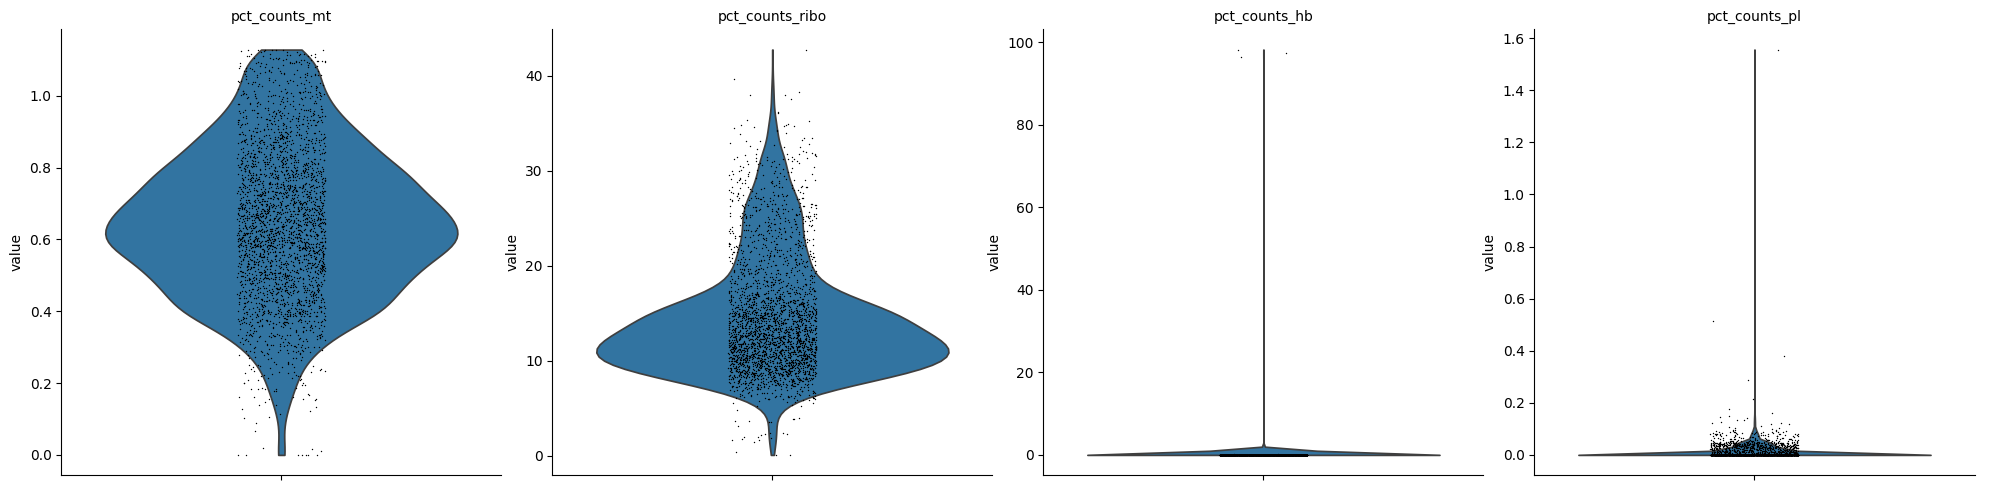

ValueError: `x`, `y`, and potential `color` inputs must all come from either `.obs` or `.var`

In [10]:
# Just a few plots to check on the quality, to be sure
sc.pl.violin(adata_merged, keys=['pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'pct_counts_pl'], multi_panel = True)
sc.pl.scatter(adata_merged, x="log1p_total_counts", y="pct_unspliced", color="ref_Celltype")
sc.pl.scatter(adata_merged, x="n_genes_by_counts", y="pct_counts_in_top_20_genes",  color="ref_Celltype")

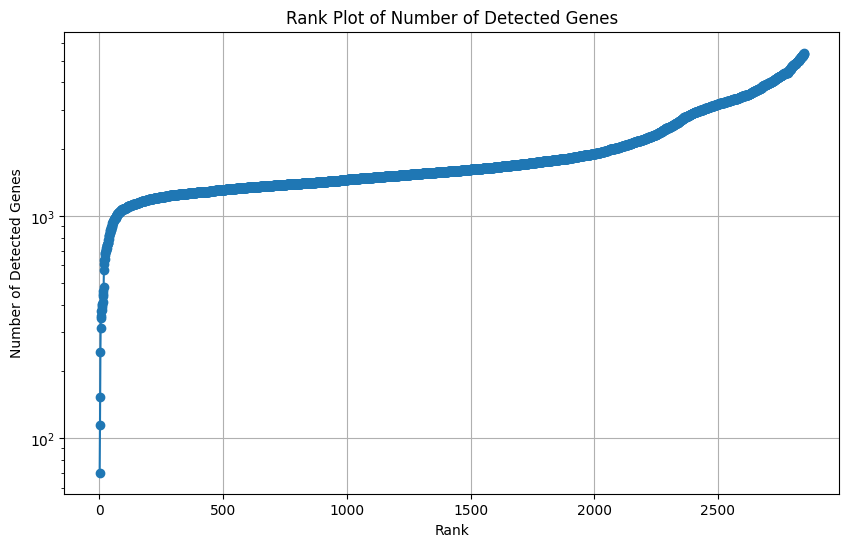

In [11]:
# this is just a plot to check the distribution of number genes detected in cells
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(adata_merged.obs['n_genes_by_counts']) + 1), adata_merged.obs['n_genes_by_counts'].sort_values(), marker='o')
plt.xlabel('Rank')
plt.ylabel('Number of Detected Genes')
plt.title('Rank Plot of Number of Detected Genes')
plt.yscale('log')
plt.grid(True)
plt.show()

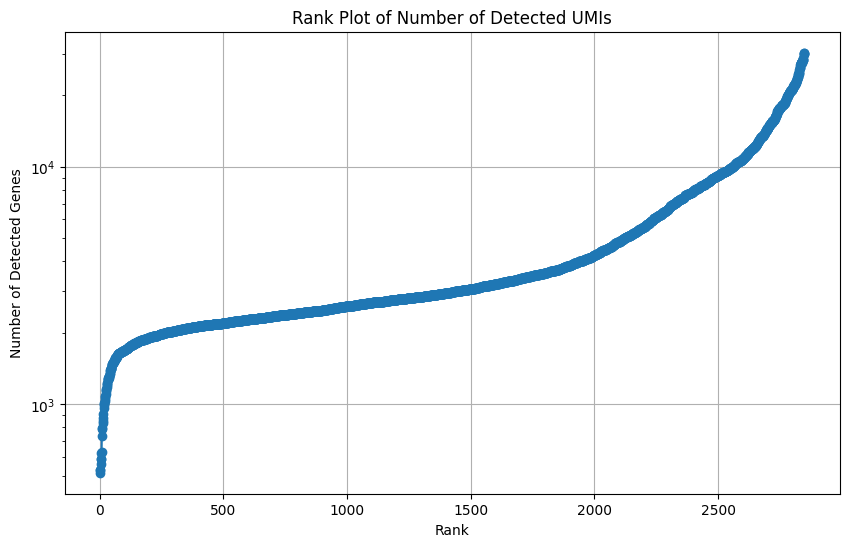

In [12]:
# this is just a plot to check the distribution of UMIs (in other words, total_counts) detected in cells

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(adata_merged.obs['total_counts']) + 1), adata_merged.obs['total_counts'].sort_values(), marker='o')
plt.xlabel('Rank')
plt.ylabel('Number of Detected Genes')
plt.title('Rank Plot of Number of Detected UMIs')
plt.yscale('log')
plt.grid(True)
plt.show()

In [13]:
print(f"Minimum pct_unspliced: {min(adata_merged.obs['pct_unspliced'])}")

print(f"Maximum pct_counts_mt: {max(adata_merged.obs['pct_counts_mt'])}")

print(f"Maximum total_counts: {max(adata_merged.obs['total_counts'])}")
print(f"Minimum total_counts: {min(adata_merged.obs['total_counts'])}")

print(f"Maximum n_genes_by_counts: {max(adata_merged.obs['n_genes_by_counts'])}")
print(f"Minimum n_genes_by_counts: {min(adata_merged.obs['n_genes_by_counts'])}")


# sc.pp.filter_cells min_genes 200 

Minimum pct_unspliced: 0.0827386492915503
Maximum pct_counts_mt: 1.128843903541565
Maximum total_counts: 30235.0
Minimum total_counts: 514.0
Maximum n_genes_by_counts: 5444
Minimum n_genes_by_counts: 70


In [14]:
sc.pp.filter_genes(adata_merged, min_cells = 3)
genes_to_exclude = ['ENSMUSG00000092341']
genes_excluded = adata_.var[adata.var.index.isin(genes_to_exclude)]
#
#
adata = adata[:,~adata.var.index.isin(genes_to_exclude)].copy()

NameError: name 'adata' is not defined

In [15]:
adata_merged.layers['soupx_counts'] = adata_merged.X.copy()

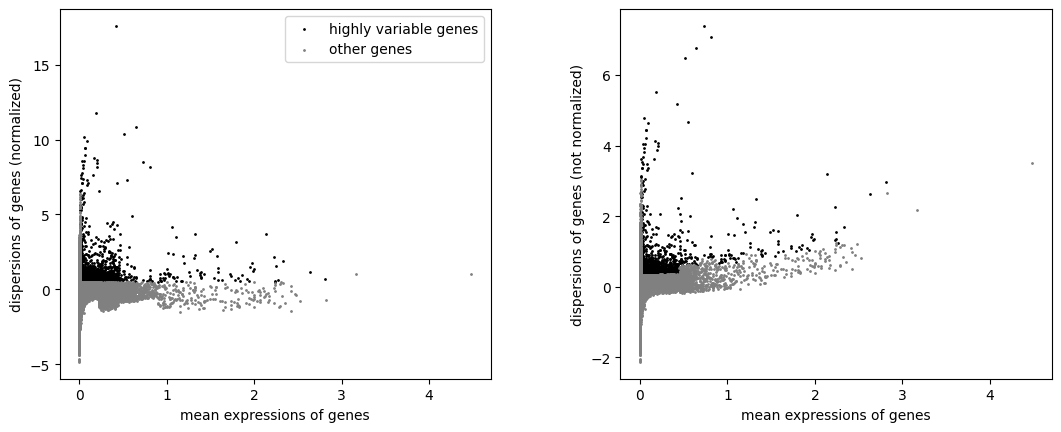

In [16]:
sc.pp.normalize_total(adata_merged)
sc.pp.log1p(adata_merged)

#you don't need to calculate this everytime, but sometimes it is just nice to see
# what are the genes with msot variance.
adata_merged.var['norm_variance'] = np.var(adata_merged.X.todense(), axis = 0).T
adata_merged.var['norm_mean'] = np.mean(adata_merged.X.todense(), axis = 0).T
adata_merged.var['norm_median'] = np.median(adata_merged.X.todense(), axis = 0).T
adata_merged.var['norm_std'] = np.sqrt(adata_merged.var['norm_variance']).T

adata_merged.raw = adata_merged

sc.pp.highly_variable_genes(adata_merged)

sc.pl.highly_variable_genes(adata_merged)



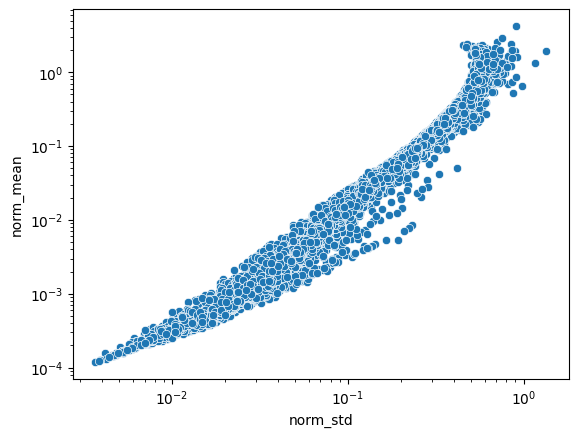

In [17]:
sns.scatterplot(adata_merged.var, x = 'norm_std', y = 'norm_mean')
plt.xscale('log')
plt.yscale('log')
plt.show()


In [18]:
# adata_check, i am declaring just, because i am filtering genes afterwards, and if 
# i want to go back, to prefiltered adata file, i can just call it back, without having to start from the beginning
adata_check = adata_merged.copy()
adata_check_obs = adata_check.obs

In [19]:
adata_merged.var.sort_values('norm_mean', ascending = False)[0:40]

gene_symbols    feature_types            gene_ids  \
ENSMUSG00000092341       Malat1  Gene Expression  ENSMUSG00000092341   
ENSMUSG00000076498        Trbc2  Gene Expression  ENSMUSG00000076498   
ENSMUSG00000049775       Tmsb4x  Gene Expression  ENSMUSG00000049775   
ENSMUSG00000029580         Actb  Gene Expression  ENSMUSG00000029580   
ENSMUSG00000024608        Rps14  Gene Expression  ENSMUSG00000024608   
ENSMUSG00000090733        Rps27  Gene Expression  ENSMUSG00000090733   
ENSMUSG00000060126         Tpt1  Gene Expression  ENSMUSG00000060126   
ENSMUSG00000037742       Eef1a1  Gene Expression  ENSMUSG00000037742   
ENSMUSG00000045128       Rpl18a  Gene Expression  ENSMUSG00000045128   
ENSMUSG00000067274        Rplp0  Gene Expression  ENSMUSG00000067274   
ENSMUSG00000003429        Rps11  Gene Expression  ENSMUSG00000003429   
ENSMUSG00000037563        Rps16  Gene Expression  ENSMUSG00000037563   
ENSMUSG00000038274          Fau  Gene Expression  ENSMUSG00000038274   
ENSMUSG00000028081       Rps3a1  Gene Expression  ENSMUSG00000028081   
ENSMUSG00000025290        Rps24  Gene Expression  ENSMUSG00000025290   
ENSMUSG00000023927        Satb1  Gene Expression  ENSMUSG00000023927   
ENSMUSG00000006333         Rps9  Gene Expression  ENSMUSG00000006333   
ENSMUSG00000057841        Rpl32  Gene Expression  ENSMUSG00000057841   
ENSMUSG00000019505          Ubb  Gene Expression  ENSMUSG00000019505   
ENSMUSG00000018293         Pfn1  Gene Expression  ENSMUSG00000018293   
ENSMUSG00000008683       Rps15a  Gene Expression  ENSMUSG00000008683   
ENSMUSG00000093674        Rpl41  Gene Expression  ENSMUSG00000093674   
ENSMUSG00000007892        Rplp1  Gene Expression  ENSMUSG00000007892   
ENSMUSG00000000740        Rpl13  Gene Expression  ENSMUSG00000000740   
ENSMUSG00000017404        Rpl19  Gene Expression  ENSMUSG00000017404   
ENSMUSG00000059291        Rpl11  Gene Expression  ENSMUSG00000059291   
ENSMUSG00000062328        Rpl17  Gene Expression  ENSMUSG00000062328   
ENSMUSG00000049109       Themis  Gene Expression  ENSMUSG00000049109   
ENSMUSG00000049517        Rps23  Gene Expression  ENSMUSG00000049517   
ENSMUSG00000046330       Rpl37a  Gene Expression  ENSMUSG00000046330   
ENSMUSG00000034165        Ccnd3  Gene Expression  ENSMUSG00000034165   
ENSMUSG00000020460       Rps27a  Gene Expression  ENSMUSG00000020460   
ENSMUSG00000030744         Rps3  Gene Expression  ENSMUSG00000030744   
ENSMUSG00000031320        Rps4x  Gene Expression  ENSMUSG00000031320   
ENSMUSG00000090862        Rps13  Gene Expression  ENSMUSG00000090862   
ENSMUSG00000061787        Rps17  Gene Expression  ENSMUSG00000061787   
ENSMUSG00000076490        Trbc1  Gene Expression  ENSMUSG00000076490   
ENSMUSG00000053044        Cd8b1  Gene Expression  ENSMUSG00000053044   
ENSMUSG00000047675         Rps8  Gene Expression  ENSMUSG00000047675   
ENSMUSG00000058546       Rpl23a  Gene Expression  ENSMUSG00000058546   

                               hsapiens_orthologs_id hsapiens_orthologs_name  \
ENSMUSG00000092341                               nan                     nan   
ENSMUSG00000076498  ENSG00000211772, ENSG00000211751            TRBC2, TRBC1   
ENSMUSG00000049775                   ENSG00000154620                  TMSB4Y   
ENSMUSG00000029580                   ENSG00000075624                    ACTB   
ENSMUSG00000024608                   ENSG00000164587                   RPS14   
ENSMUSG00000090733                               nan                     nan   
ENSMUSG00000060126                               nan                     nan   
ENSMUSG00000037742                               nan                     nan   
ENSMUSG00000045128                   ENSG00000105640                  RPL18A   
ENSMUSG00000067274                               nan                     nan   
ENSMUSG00000003429                   ENSG00000142534                   RPS11   
ENSMUSG00000037563                   ENSG00000105193                   RPS16   
ENSMUSG00000038274        

Bellow we have basically the clustering pipeline.
1. adata_check, as mentioned before, just, it is useful if we want to try different clustering or dimensionality reduction methods.
2. filter to select only highly variable genes. this is good only to free up some memory, if calulating scale and regression
3. scaling: THIS IS OPTIONAL. You can check if you like a UMAP with scaling or without. I liked for my data on the macaque, the one with scaling. But if it looks better without, then don't scale. it is not a must,.
4. regress out: THIS IS EVEN MORE SO OPTIONAL. Only regress if you have scaled before. Regress out, means to calculate or normalise for a technical effect that you might see in the umap. Only regress if you think that your cluster is emphasising on a technical aspect, such as pct_mitochondria or total counts per cell. then you could regress pct_counts_mt or total_counts if you so wish
5. pca: calculate the principal components. You can leave it as is, it is important to do it
6.  Neighbors. Calculates nearest neighbours. You can tweak the number of neighbours if you want. but i would recommend to leave it there. I found that 10 neighbours gives you a good numebr so that your umap manages to detected celltypes that are less represented. So it is sensible to detecting smaller clusters. 
7. Calculate the UMAP coordinates.
8. check how your umap looks!

Note that if you want to compare how umaps look scaled vs not scaled, or with or without regression, try summarising it in a powerpoint slide. and then compare them and check which one you think reflects best the biology based on your understanding. However be aware, distances in UMAP across clusters are NOT maintained. Only local distances matter. We are selecting 10 neighbours, so the position of a single cell, is based on its most proximal 10 neighbours. Everything outside that was not directly taken into acount.

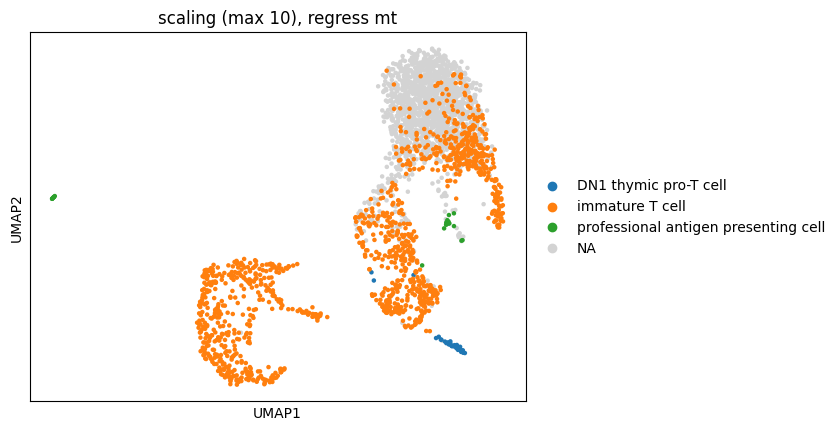

In [21]:

adata_merged = adata_check.copy()
adata_merged = adata_merged[:, adata_merged.var.highly_variable].copy()
sc.pp.scale(adata_merged, max_value=10)
#sc.pp.regress_out(adata, ['pct_counts_mt'])
sc.pp.pca(adata_merged)
sc.pp.neighbors(adata_merged, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_merged, method = 'umap')
sc.pl.umap(adata_merged, color = 'cell_ontology_class',title = 'scaling (max 10), regress mt')



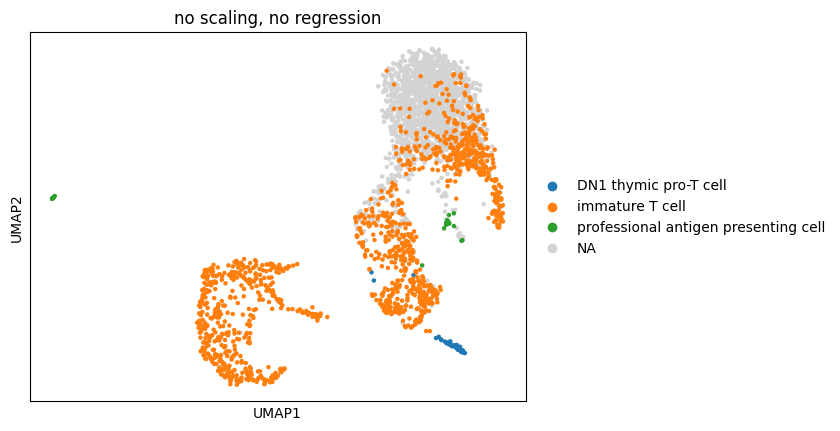

In [22]:
sc.pl.umap(adata_merged, color = 'cell_ontology_class',title = 'no scaling, no regression')


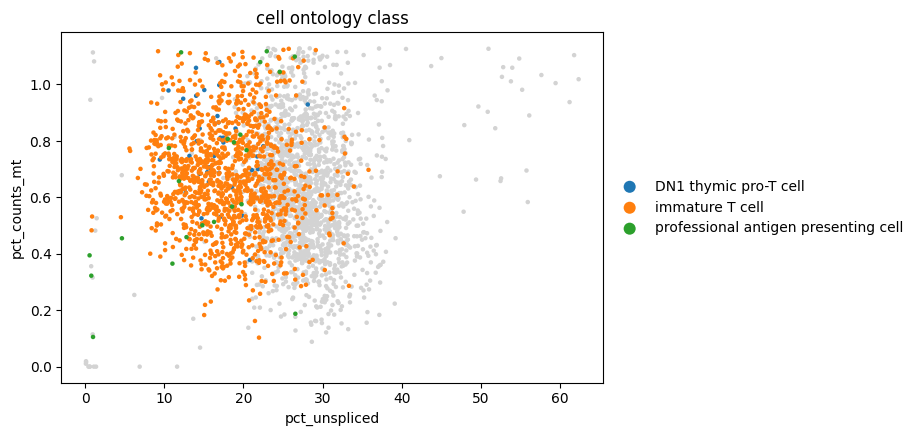

In [23]:
# this is just checking if there is a large difference between mitochondria genes and the clusters. 
# sometimes this makes sense biologically, sometimes not
sc.pl.scatter(adata_merged, x = 'pct_unspliced', y = 'pct_counts_mt', color = 'cell_ontology_class')

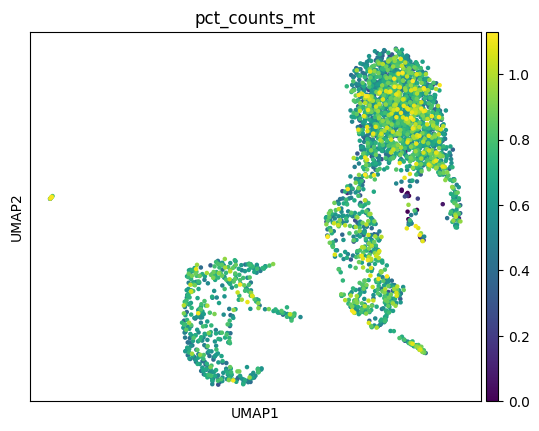

In [24]:
sc.pl.umap(adata_merged, color = 'pct_counts_mt')

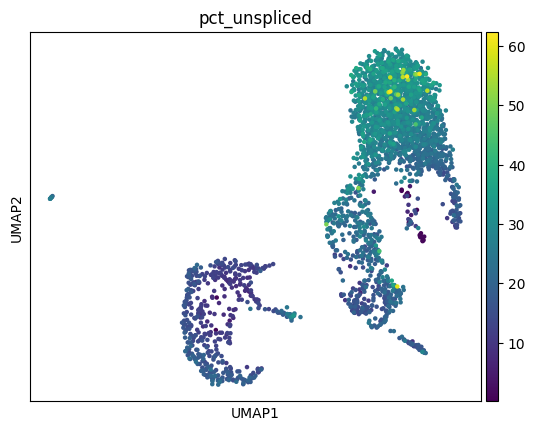

In [25]:
sc.pl.umap(adata_merged, color = 'pct_unspliced')

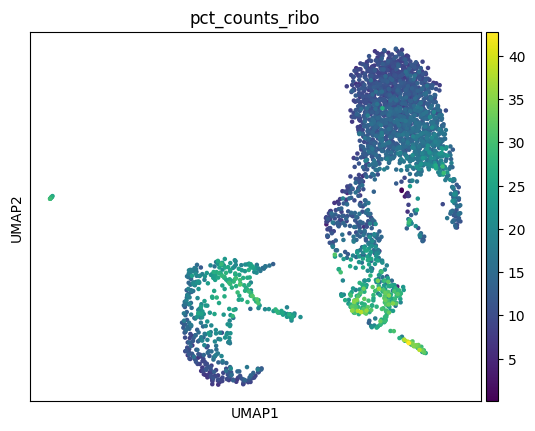

In [26]:
sc.pl.umap(adata_merged, color = 'pct_counts_ribo')

In [27]:
# we do this to get all our genes back, we had filtered them out before, rememeber? 
adata_merged = adata_merged.raw.to_adata() 

In [28]:
# we are usimg leiden to cluster the cells. You can check what the difference is in clusters, 
# between high and low resolution. The higher resolution the more clusters there are. 
# I like using 2, but if the cluser number is just way too high then better if you go for a lower one.
sc.tl.leiden(adata_merged, resolution = 1, key_added = 'leiden_1')
sc.tl.leiden(adata_merged, resolution = 2, key_added = 'leiden_2')

/var/folders/8p/xlqh16zs5s12cjly36xp9prr0000gn/T/ipykernel_27418/3280493518.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_merged, resolution = 1, key_added = 'leiden_1')


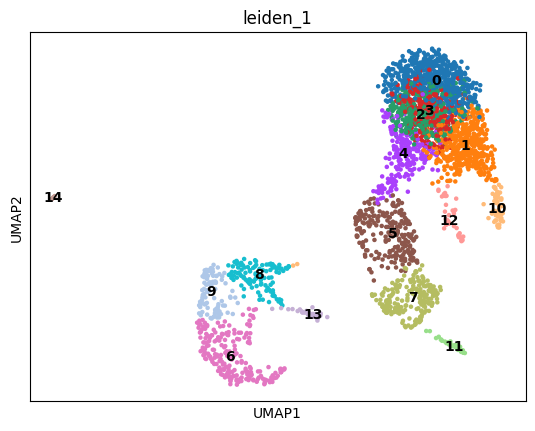

In [29]:
sc.pl.umap(adata_merged, color = 'leiden_1', legend_loc = 'on data')


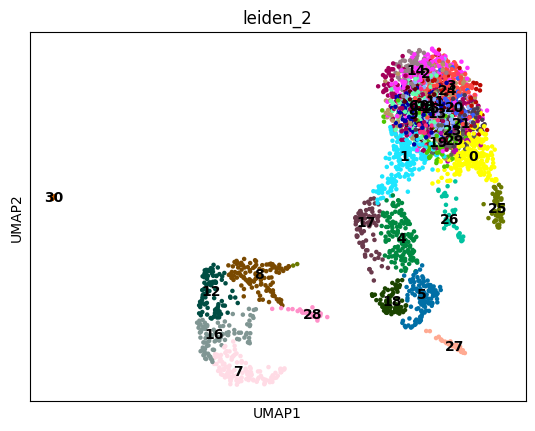

In [30]:
sc.pl.umap(adata_merged, color = 'leiden_2', legend_loc = 'on data')


In [31]:
adata_merged.obs

pct_unspliced  doublet_score  predicted_doublet  n_genes_by_counts  \
0         23.511635       0.044776              False               1657   
1         11.749446       0.074197              False               5089   
2         25.000000       0.088384              False               1342   
3         16.141384       0.042748              False               1737   
4         28.976641       0.028606              False               1223   
...             ...            ...                ...                ...   
3341      27.234490       0.133333              False               1525   
3342      29.256323       0.014559              False               1548   
3343      30.494406       0.094040              False               1567   
3344      19.342554       0.018381              False               1869   
3345      30.850595       0.056985              False               1390   

      log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
0                    7.413367        3453.0            8.147288   
1                    8.535033       24627.0           10.111639   
2                    7.202661        2180.0            7.687539   
3                    7.460490        3550.0            8.174985   
4                    7.109879        1895.0            7.547502   
...                       ...           ...                 ...   
3341                 7.330405        2950.0            7.989899   
3342                 7.345365        2811.0            7.941651   
3343                 7.357556        2912.0            7.976939   
3344                 7.533694        5162.0            8.549273   
3345                 7.237778        2377.0            7.774015   

      pct_counts_in_top_20_genes  total_counts_mt  log1p_total_counts_mt  ...  \
0                      14.914567             27.0               3.332205  ...   
1                      12.173631            241.0               5.488938  ...   
2                      10.917431             12.0               2.564949  ...   
3                      12.591549             20.0               3.044523  ...   
4                      11.240106              6.0               1.945910  ...   
...                          ...              ...                    ...  ...   
3341                   13.254237             15.0               2.772589  ...   
3342                   15.652793             21.0               3.091043  ...   
3343                   16.243132              9.0               2.302585  ...   
3344                   18.151879             40.0               3.713572  ...   
3345                   12.663021             14.0               2.708050  ...   

      total_counts_pl  log1p_total_counts_pl  pct_counts_pl       ori_barcode  \
0                 0.0               0.000000       0.000000  AAACCTGAGACAGGCT   
1                 3.0               1.386294       0.012182  AAACCTGAGAGTCTGG   
2                 0.0               0.000000       0.000000  AAACCTGAGATGGCGT   
3                 0.0               0.000000       0.000000  AAACCTGCAGGAATGC   
4                 0.0               0.000000       0.000000  AAACCTGCAGTATAAG   
...               ...                    ...            ...               ...   
3341              0.0               0.000000       0.000000  TTTGTCAAGGCTCATT   
3342              0.0               0.000000       0.000000  TTTGTCAGTACGCACC   
3343              0.0               0.000000       0.000000  TTTGTCATCATTCACT   
3344              0.0               0.000000       0.000000  TTTGTCATCGAACTGT   
3345              0.0               0.000000       0.000000  TTTGTCATCTTTACGT   

                         barcode                        cell  \
0     10X_P7_11_AAACCTGAGACAGGCT  10X_P7_11_AAACCTGAGACAGGCT   
1     10X_P7_11_AAACCTGAGAGTCTGG  10X_P7_11_AAACCTGAGAGTCTGG   
2     10X_P7_11_AAACCTGAGATGGCGT                         NaN   
3     10X_P7_11_AAACCTGCAGGAATGC  10X_P7_11_AAACCTGCAGGAATGC   
4     10X_P7_11_AAACCT

In [33]:
# This is highly optional too, if you see a clusterthat you want to split into two,
# because it does show a distinction in the umap coordinates but you don't want to run to a higher leiden resolution, 
# you can do sub clustering of that cluster. In this example i subclustered cluster 17 in leiden_2 resolution.
# Drop the 'subclustering_temp' and 'leiden_2_sub' columns if they exist
columns_to_drop = ['subclustering_temp', 'leiden_2_sub']
existing_columns_to_drop = [col for col in columns_to_drop if col in adata_merged.obs.columns]

# Now drop the existing columns
adata_merged.obs = adata_merged.obs.drop(existing_columns_to_drop, axis=1)

In [34]:

#adata = subcluster_cells_(adata, prev_clustering_column = 'leiden_2',
#                          ct_to_cluster = '14', subcluster_column_name = 'leiden_2_sub',
#                          subcluster_column_temp = 'subclustering_temp', resolution = 0.2)
#
#
#adata = subcluster_cells_(adata, prev_clustering_column = 'leiden_2',
#                          ct_to_cluster = '19', subcluster_column_name = 'leiden_2_sub',
#                          subcluster_column_temp = 'subclustering_temp', resolution = 0.2)
#
#
#

In [35]:
adata_merged = subcluster_cells_(adata_merged, prev_clustering_column = 'leiden_2',
                          ct_to_cluster = '14', subcluster_column_name = 'leiden_2_sub',
                          subcluster_column_temp = 'subclustering_temp', resolution = 0.2)
#
#
#adata = subcluster_cells_(adata, prev_clustering_column = 'leiden_2',
#                          ct_to_cluster = '20', subcluster_column_name = 'leiden_2_sub',
#                          subcluster_column_temp = 'subclustering_temp', resolution = 0.2)
#
#


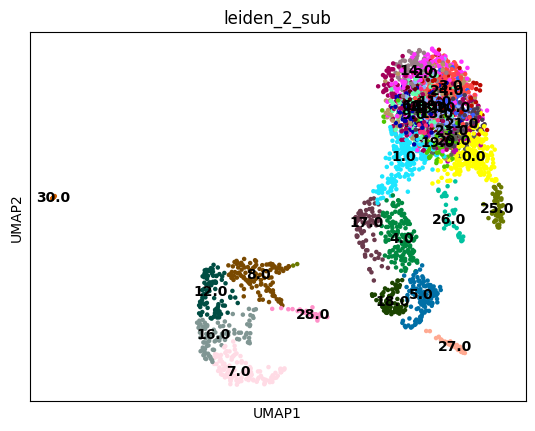

In [36]:
# these are the results after subclustering
sc.pl.umap(adata_merged, color = 'leiden_2_sub', legend_loc = 'on data')


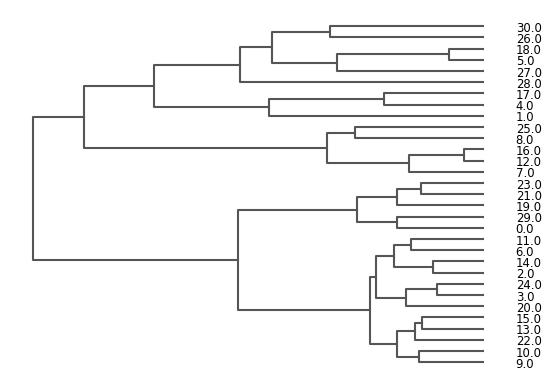

<Axes: >

In [37]:
# calculate dendrogram of clusters
sc.tl.dendrogram(adata_merged, 'leiden_2_sub')
sc.pl.dendrogram(adata_merged, 'leiden_2_sub', orientation = 'left')

In [38]:
print(adata_merged.var.columns)

Index(['gene_symbols', 'feature_types', 'gene_ids', 'hsapiens_orthologs_id',
       'hsapiens_orthologs_name', 'mt', 'ribo', 'tf', 'hb', 'pl', 'rRNA',
       'chromosome_loc', 'pcg', 'exc', 'cyt', 'mem', 'n_cells_by_counts',
       'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts',
       'total_counts', 'log1p_total_counts', 'n_cells', 'norm_variance',
       'norm_mean', 'norm_median', 'norm_std'],
      dtype='object')


In [39]:
adata_merged.obs.columns

Index(['pct_unspliced', 'doublet_score', 'predicted_doublet',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_pl',
       'log1p_total_counts_pl', 'pct_counts_pl', 'ori_barcode', 'barcode',
       'cell', 'cell_ontology_class', 'class_label', 'leiden_1', 'leiden_2',
       'subclustering_temp', 'leiden_2_sub'],
      dtype='object')

/Users/amandheer/miniconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/amandheer/miniconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/amandheer/miniconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:434: PerformanceWarning: DataFram

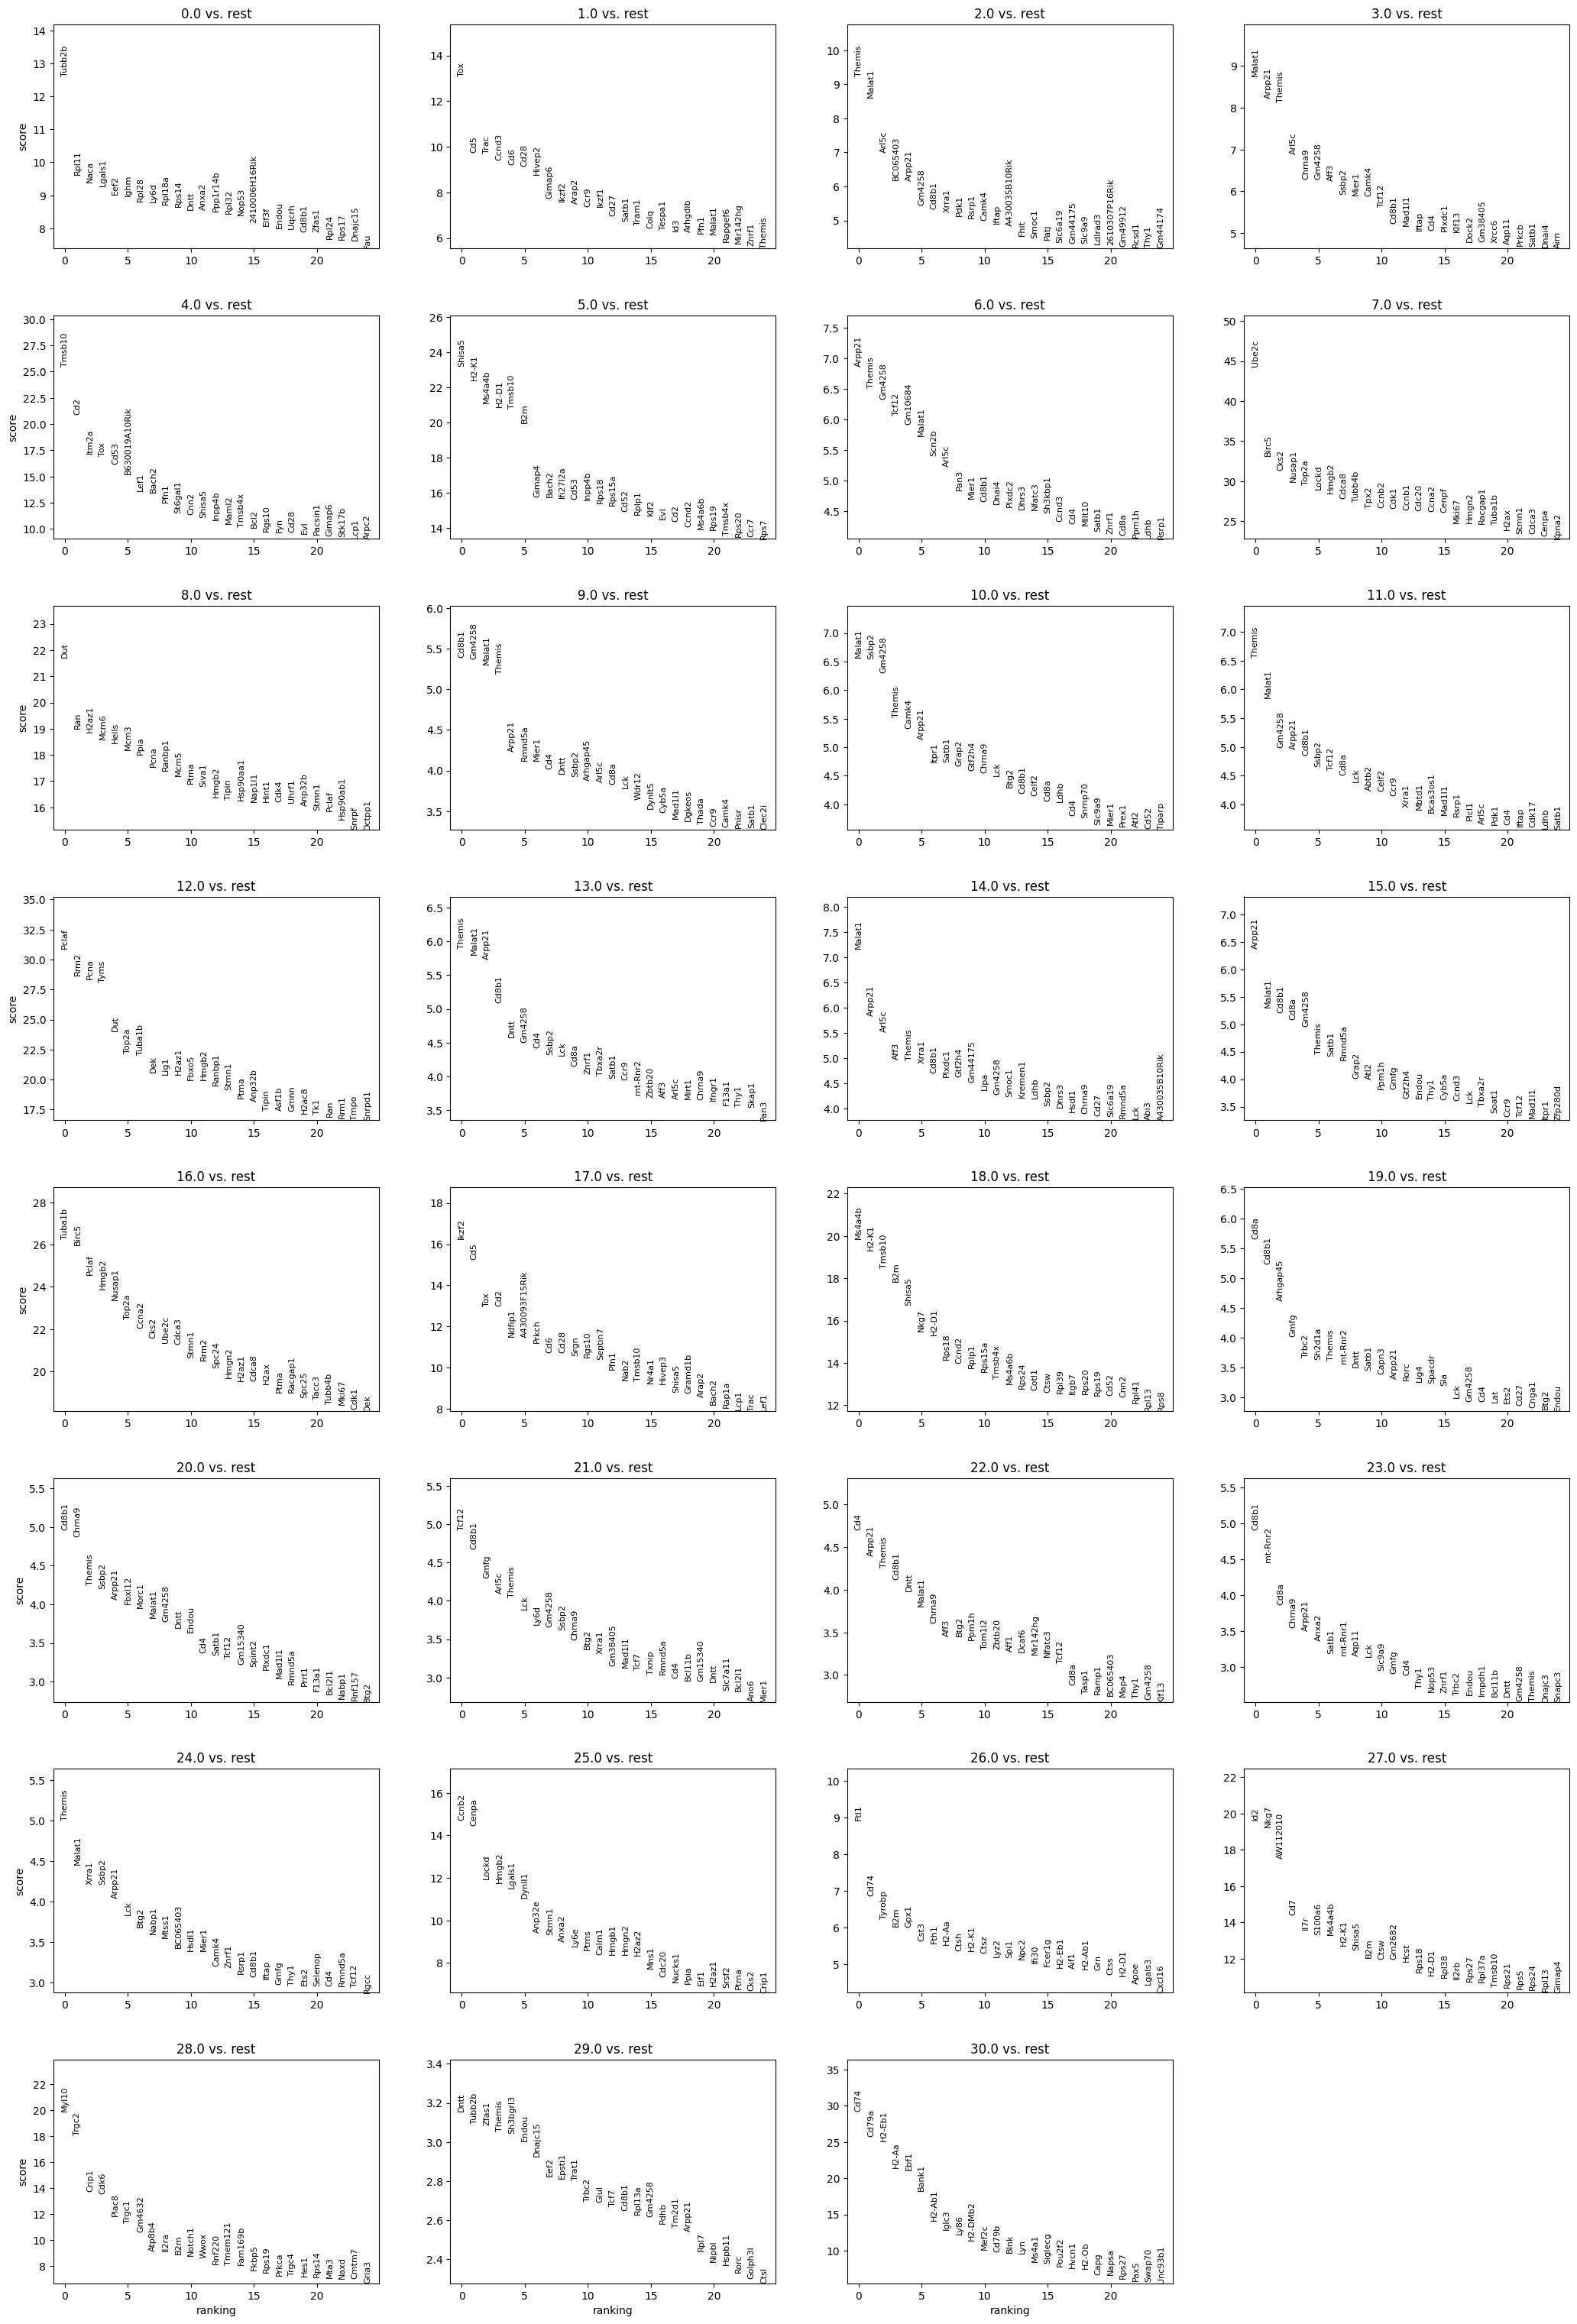

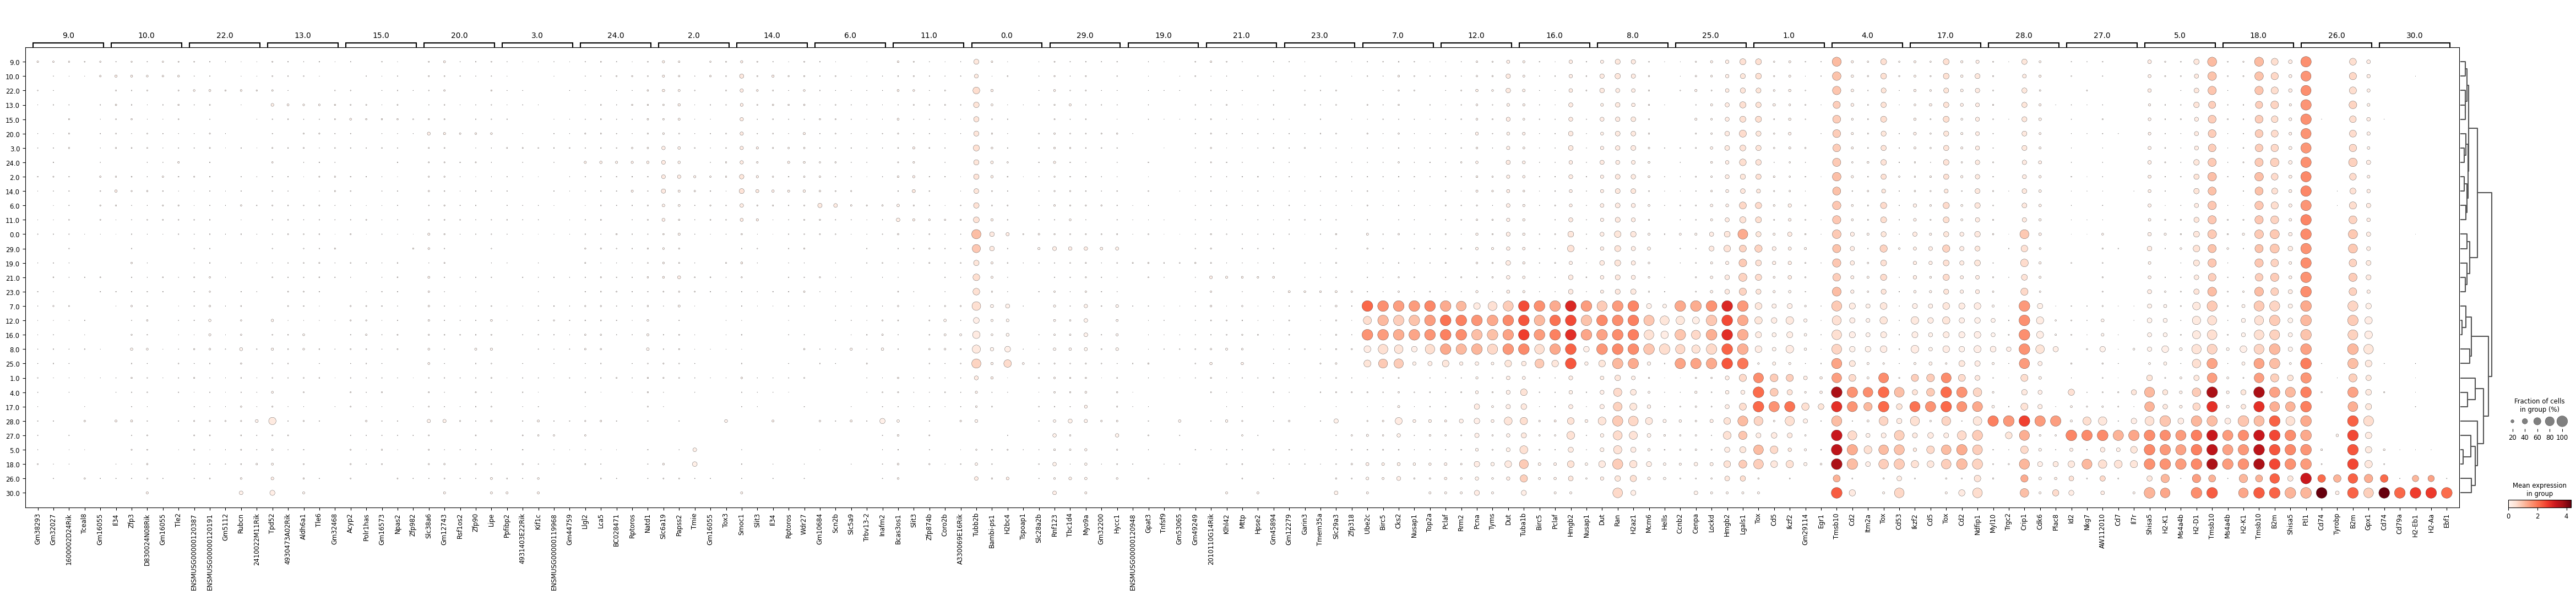

In [40]:
# calculate most differentially expressed genes between each cluster. This is based on leiden_2_sub; 
# if you have another category you need to specify this, change leiden_2_sub, for your wished cluster names
sc.tl.rank_genes_groups(adata_merged, groupby = 'leiden_2_sub', method = 't-test_overestim_var')                                
sc.pl.rank_genes_groups(adata_merged, n_genes=25, sharey=False, gene_symbols='gene_symbols')
sc.pl.rank_genes_groups_dotplot(adata_merged, n_genes=5, groupby="leiden_2_sub",gene_symbols = 'gene_symbols', min_logfoldchange = 2 )


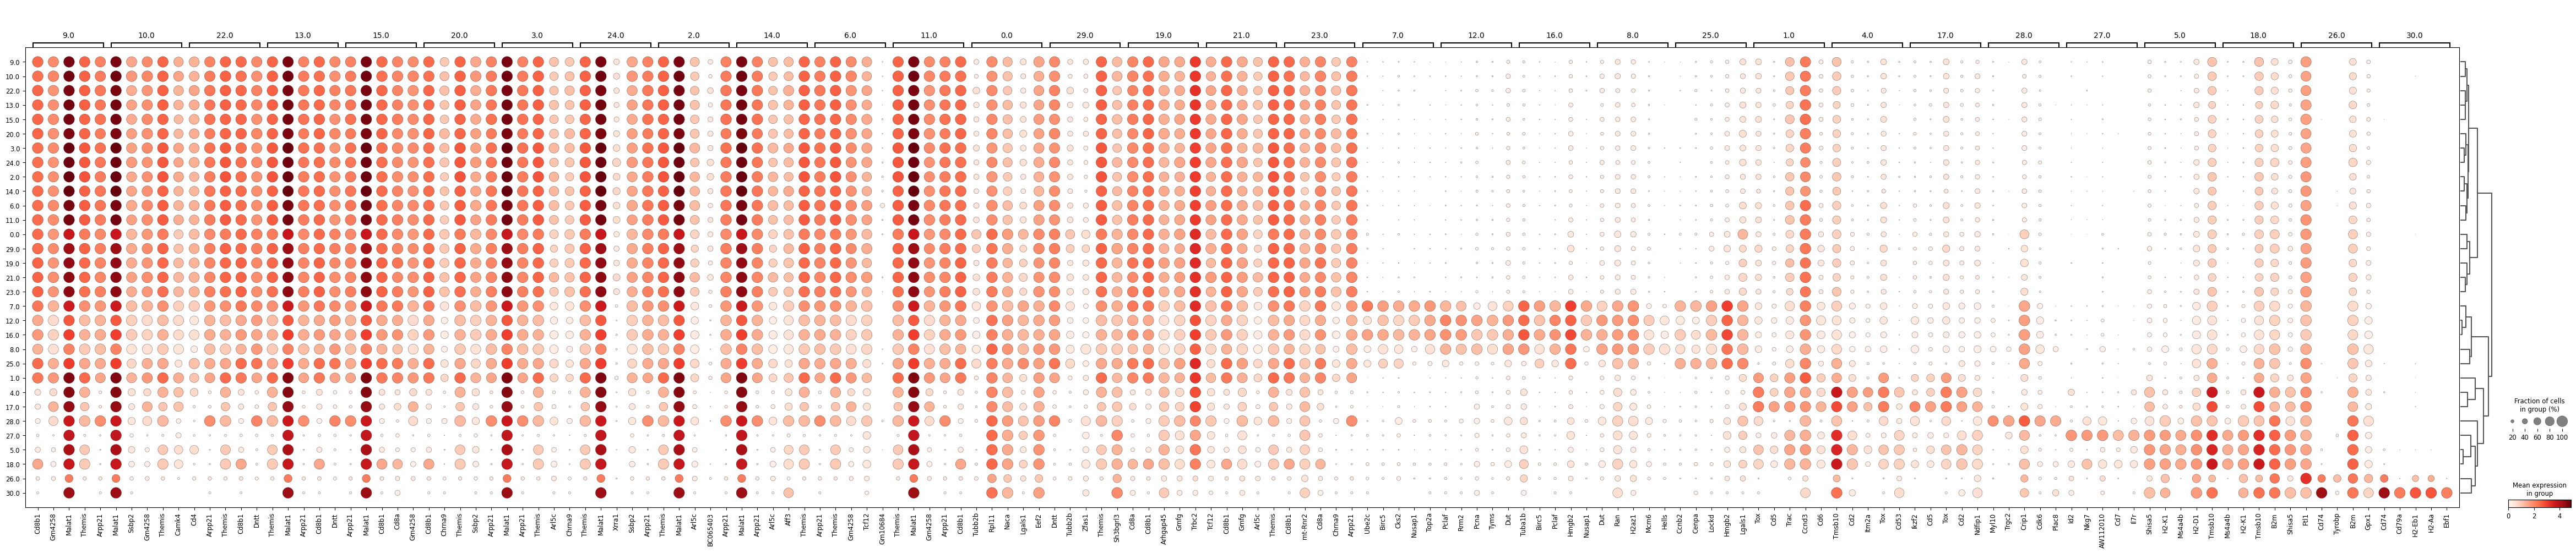

In [41]:
sc.pl.rank_genes_groups_dotplot(adata_merged, n_genes=5, groupby="leiden_2_sub",gene_symbols = 'gene_symbols' )


In [42]:
adata_merged.uns['dendrogram_leiden_2_sub']['categories_ordered']

['9.0',
 '10.0',
 '22.0',
 '13.0',
 '15.0',
 '20.0',
 '3.0',
 '24.0',
 '2.0',
 '14.0',
 '6.0',
 '11.0',
 '0.0',
 '29.0',
 '19.0',
 '21.0',
 '23.0',
 '7.0',
 '12.0',
 '16.0',
 '8.0',
 '25.0',
 '1.0',
 '4.0',
 '17.0',
 '28.0',
 '27.0',
 '5.0',
 '18.0',
 '26.0',
 '30.0']

categories: 0.0, 1.0, 2.0, etc.
var_group_labels: cycling cells, Endothelial cells, EC Increased cell cycling, etc.


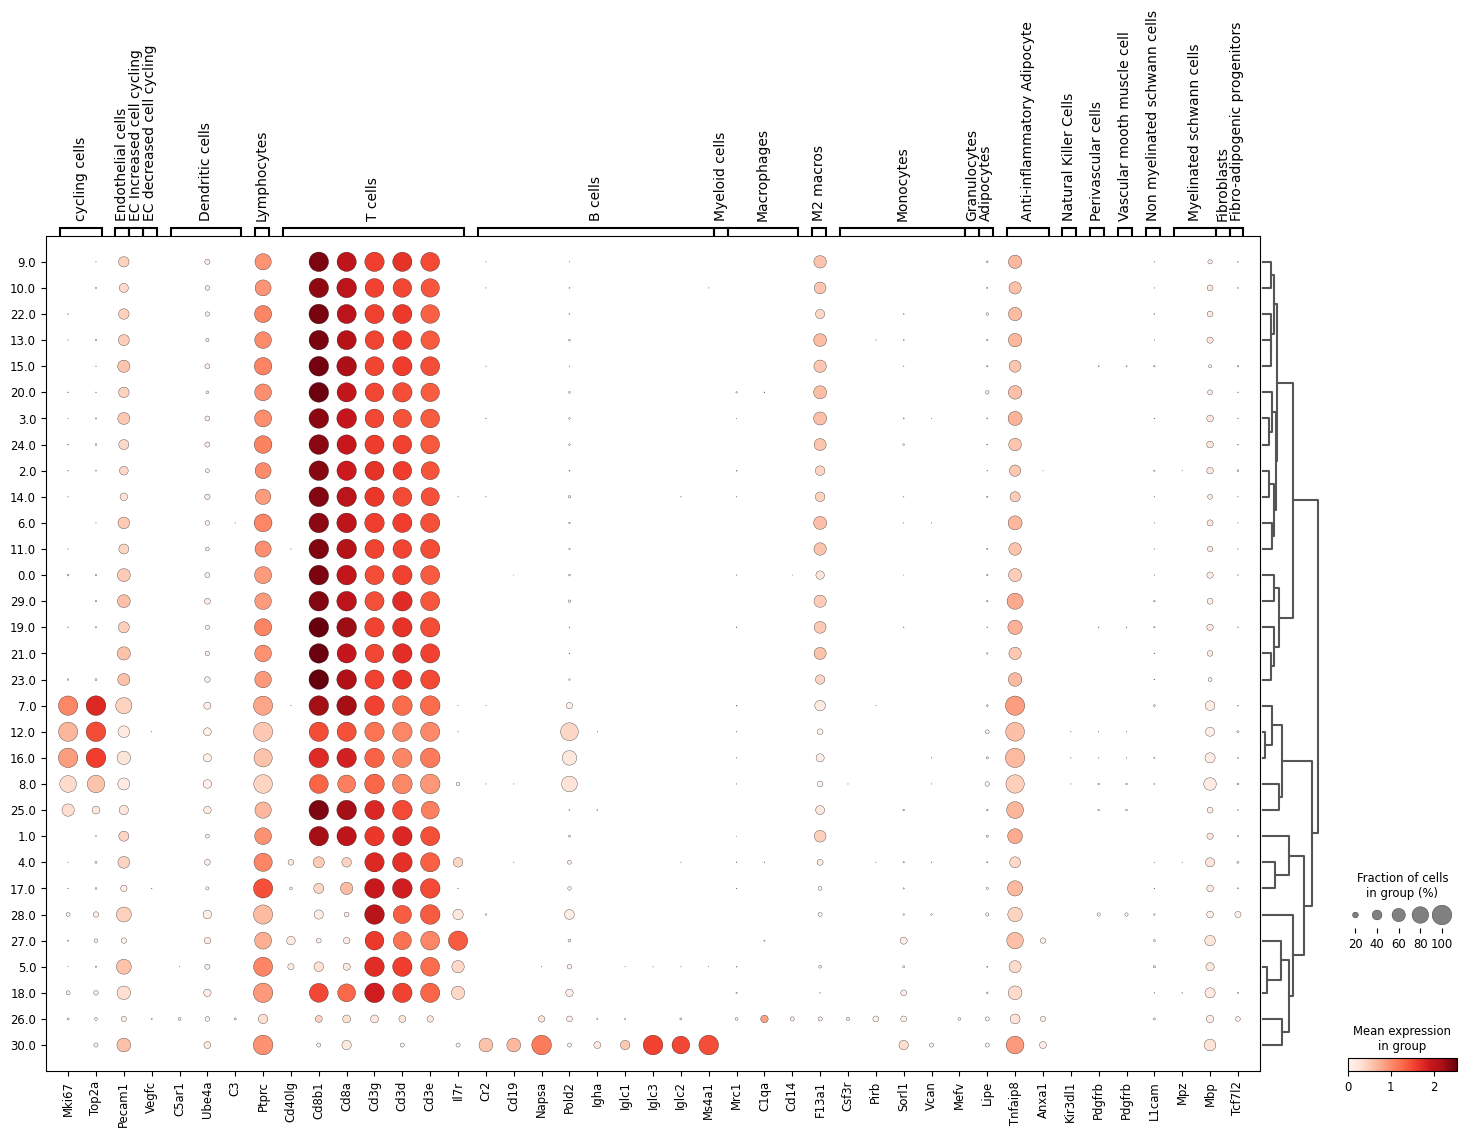

In [43]:
# a dictionary of markers, that i use to name the clusters. With their source. 

markers = { 
    'cycling cells':['TOP2A', 'MKI67'],
    #'Atrial cardiomyocyte':['NPPA', 'MYL7', 'MYL4'], #https://www.nature.com/articles/s41586-020-2797-4
          # 'ventricular cardiomyocytes':['MYH7', 'MYL2', 'FHL2'], #https://www.nature.com/articles/s41586-020-2797-4
   
    'Endothelial cells':['PECAM1', 'VWF', 'CD34'],
    

    'EC Increased cell cycling':['NR2F2'],#https://www.nature.com/articles/s41569-022-00770-1/figures/1
    'EC decreased cell cycling':[ 'VEGFC'],#https://www.nature.com/articles/s41569-022-00770-1/figures/1

    #'Lymphatic ECs':['LYVE1', 'PROX1'], #https://www.nature.com/articles/s43587-024-00613-3
   # 'Arterial ECs':['HEY1', 'HEY2', 'IFGBP3', 'SEMA3G'],#https://www.nature.com/articles/s41586-024-07348-6/figures/15
    # 'Venous':['ACKR1', 'POSTN', 'TLL1'], #https://www.nature.com/articles/s41586-024-07348-6/figures/15
        #   'Arteriole':['RGCC', 'CD36'],#https://www.nature.com/articles/s43587-024-00613-3/
   # 'Capillary':['CA4', 'CD300LG', 'RGCC', 'LPL'],#https://www.nature.com/articles/s41586-024-07348-6/figures/15
    #'atrial ec':['SMOC1', 'INHBA', 'NPR3'],#https://www.nature.com/articles/s41586-020-2797-4

'Dendritic cells': ['IGHA', 'IGC3', 'C5AR1', 'C3', 'UBE4A', 'GZMB'],
    
  'Lymphocytes': ['PTPRC'],
        'T cells':[ 'IL7R', 'CD3E', 'CD3G','CD8A','CD8B', 'CD3D', 'CD40LG', ],#https://www.nature.com/articles/s43587-024-00613-3
    'B cells':['IGLC3', 'IGHA2', 'NAPSA', 'POLD2', 'CD19', 'CR2', 'MS4A1'],

    'Myeloid cells':['HLA-DRA', 'CD11B'],
    'Macrophages':[    'CD14','MARCO','C1QA','CD163', 'MRC1'   ],# https://www.nature.com/articles/s43587-024-00613-3
    'M2 macros':['LYVE1', 'F13A1'],#https://www.nature.com/articles/s43587-024-00613-3
    'Monocytes':['VCAN', 'S100A8', 'LILRA5', 'LILRB2', 'CSF3R', 'OLR1', 'MEFV', 'SORL1', 'FCGR3A'],#https://www.nature.com/articles/s43587-024-00613-3
    'Granulocytes': ['CD66b'], #https://ashpublications.org/blood/article/91/2/663/258917/Mice-Transgenic-for-the-Human-CGM6-Gene-Express

    
            'Adipocytes': ['ADIPOQ', 'FABP4', 'LIPE', 'PLIN1'], #hpa
        'Anti-inflammatory Adipocyte':['ANXA1', 'TNFAIP8'],
    'Natural Killer Cells': ['KIR2DL4'],

     'Perivascular cells':['NG2', 'CD146', 'ACTA2', 'PDGFRB'],#https://www.frontiersin.org/journals/cardiovascular-medicine/articles/10.3389/fcvm.2018.00154/full
   # 'Pericytes':['RGS5', 'ABCC9', 'STEAP4', 'COL5A3'], #https://www.nature.com/articles/s43587-024-00613-3/figures/14 # https://www.nature.com/articles/s41586-024-07348-6

    'Vascular mooth muscle cell':['PDGFRB','ACTA2', 'MYH11', 'TAGLN', 'MYH11', 'CNN1'],#https://www.nature.com/articles/s41586-024-07348-6/figures/15

    
    
    'Non myelinated schwann cells':['CDH19', 'L1CAM'],#https://www.nature.com/articles/s43587-024-00613-3

        'Myelinated schwann cells':['MPZ', 'MBP'],#https://www.nature.com/articles/s43587-024-00613-3

    

    'Fibroblasts':['DCN', 'PDGFRA', 'COL3A1', 'FBN1'],#https://www.nature.com/articles/s43587-024-00613-3
      'Fibro-adipogenic progenitors':[ 'CD34', 'PDGFRA', 'TCF7L2',],#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8651418/ , https://link.springer.com/article/10.1186/s13395-021-00265-6
    
#   'mesothelial cells':['MSLN', 'WT1', 'BNC1'], #https://www.nature.com/articles/s41586-020-2797-4/figures/8
    

          }



markers = htmd(markers, adata_merged)
sc.pl.dotplot(adata_merged, markers, "leiden_2_sub", dendrogram=True, gene_symbols = 'gene_symbols' )


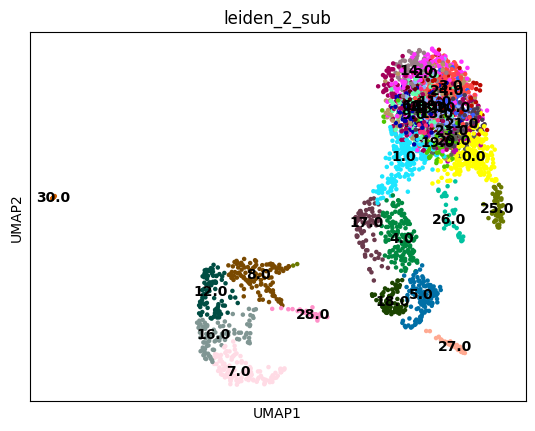

In [44]:
sc.pl.umap(adata_merged, color = "leiden_2_sub", legend_loc = "on data")

In [45]:
# if you want for your report, you can print things here, and save it as a csv file. 
# that way you have everything very ordered and reproducible 
for key, value in markers.items():
    for marker in value:
        print(key + ', ' + marker + ', ' + 'thymus')

cycling cells, Mki67, thymus
cycling cells, Top2a, thymus
Endothelial cells, Pecam1, thymus
EC decreased cell cycling, Vegfc, thymus
Dendritic cells, C5ar1, thymus
Dendritic cells, Ube4a, thymus
Dendritic cells, C3, thymus
Lymphocytes, Ptprc, thymus
T cells, Cd40lg, thymus
T cells, Cd8b1, thymus
T cells, Cd8a, thymus
T cells, Cd3g, thymus
T cells, Cd3d, thymus
T cells, Cd3e, thymus
T cells, Il7r, thymus
B cells, Cr2, thymus
B cells, Cd19, thymus
B cells, Napsa, thymus
B cells, Pold2, thymus
B cells, Igha, thymus
B cells, Iglc1, thymus
B cells, Iglc3, thymus
B cells, Iglc2, thymus
B cells, Ms4a1, thymus
Macrophages, Mrc1, thymus
Macrophages, C1qa, thymus
Macrophages, Cd14, thymus
M2 macros, F13a1, thymus
Monocytes, Csf3r, thymus
Monocytes, Pirb, thymus
Monocytes, Sorl1, thymus
Monocytes, Vcan, thymus
Monocytes, Mefv, thymus
Adipocytes, Lipe, thymus
Anti-inflammatory Adipocyte, Tnfaip8, thymus
Anti-inflammatory Adipocyte, Anxa1, thymus
Natural Killer Cells, Kir3dl1, thymus
Perivascular c

In [50]:
# labeling
# based on leiden 2 
# here i have the detailed labels
labels ={
 '10.0' :  'T-cells' ,
 '0.0' :   'T-cells',
 '23.0' :  'T-cells' ,
 '25.0' :  'T-cells' ,
 '1.0' :   'T-cells',
    '26.0': 'Lymphocytes',
'2.0': 'T-cells',
 '5.0' :   'T-cells',
 '9.0' :   'T-cells',
#'9.1' : 'Lymphocytes',
 '8.0' :   'T-cells',
 '4.0' :   'T-cells',
 '11.0' :  'T-cells' ,
    '27.0': 'T-cells',
    '28.0': 'T-cells',
    '29.0': 'T-cells',
    '30.0': 'B-cells', 
 '16.0' :  'T-cells' ,
#'16.1': 'T-cells',
 '18.0' :  'T-cells' ,
 '6.0' :    'T-cells'       ,
 '14.0' :  'T-cells'         ,
 '13.0' :  'T-cells'         ,
 '24.0' :  'T-cells'         ,
 '19.0' : 'T-cells'          ,
 '17.0' :  'T-cells'         ,
 #'17.1' :  'Monocytes'         ,
 '20.0' :     'T-cells' ,
 #'20.1' :     'Adipocytes' ,
 '15.0' :      'T-cells'     ,
 '21.0' :       'T-cells'      ,
 '22.0' :  'T-cells'        ,
 '12.0' : 'Cycling cells'  ,
 '7.0' :  'T-cells' ,
 '2.0' :  'T-cells' ,
 '3.0' :  'T-cells' 
  

}


adata_merged.obs['cell_type_name'] = adata_merged.obs['leiden_2_sub'].map(labels)

# here i have the simplified labels. you only need one, but if you want to be more specific, 
# this is the way you could do this

#labels_simple = {
# '10.0' :  'Cardiomyocytes' ,
# '0.0' :   'Cardiomyocytes',
 #'23.0' :  'Cardiomyocytes' ,
 #'25.0' :  'Cardiomyocytes' ,
 #'1.0' :   'Cardiomyocytes',
 #'5.0' :   'Cardiomyocytes',
 #'9.0' :   'Cardiomyocytes',
 #'8.0' :   'Cardiomyocytes',
 #'4.0' :   'Cardiomyocytes',
 #'11.0' :  'Cardiomyocytes' ,
 #'16.0' :  'Cardiomyocytes' ,
 #'18.0' :  'Cardiomyocytes' ,
 #'6.0' :  'Vascular endothelial cells',
 #'14.0' : 'Vascular endothelial cells',
 #'13.0' : 'Vascular endothelial cells',
 #'24.0' :  'Lymphatic endothelial cells'         ,
 #'19.0' : 'T cells'          ,
 #'17.0' :  'Macrophages'         ,
 #'17.1' :  'Monocytes'         ,
 #'20.0' :     'Adipocytes' ,
# '20.1' :     'Adipocytes' ,
 #'15.0' :      'Pericytes'     ,
 #'21.0' :       'Vascular smooth muscle cells'      ,
 #'22.0' :  'Schwann cells'        ,
 #'12.0' : 'Fibroblasts'  ,
 #'7.0' :  'Fibroblasts' ,
 #'2.0' :  'Fibroblasts' ,
 #'3.0' :  'Fibroblasts' 
  

#}


#adata_merged.obs['cell_type_simple'] = adata_merged.obs['leiden_2_sub'].map(labels)

# i rate my labeling confidence, on a scale of 0 to 5. It is purely based on feeling, but its good to have. Just in case.
confidence ={
 '10.0' : 5, # 'Ventricular cardiomyocytes' ,
 '0.0' :  5, # 'Ventricular cardiomyocytes',
 '23.0' : 5, # 'Ventricular cardiomyocytes' ,
 '25.0' : 5, # 'Ventricular cardiomyocytes' ,
 '1.0' :  5, # 'Ventricular cardiomyocytes',
 '5.0' :  5, # 'Ventricular cardiomyocytes',
 '9.0' :  5, # 'Ventricular cardiomyocytes',
 '8.0' :  5, # 'Ventricular cardiomyocytes',
 '4.0' :  5, # 'Ventricular cardiomyocytes',
 '11.0' : 5, # 'Ventricular cardiomyocytes' ,
 '16.0' : 5, # 'Ventricular cardiomyocytes' ,
 '18.0' : 5, # 'Ventricular cardiomyocytes' ,
 '6.0' :  5, #  'Capillary endothelial cells 1'       ,
 '14.0' : 5, # 'Arterial enothelial cells'         ,
 '13.0' : 5, # 'Capilllary endothelial cells 2'         ,
 '24.0' : 5, # 'Lymphatic endothelial cells'         ,
 '19.0' : 4, #'T cells'          ,
 '17.0' : 5, # 'Macrophages'         ,
 '17.1' : 5, # 'Monocytes'         ,
 '20.0' : 5, #    'Adipocytes (anti-inflammatory)' ,
# '20.1' : 5, #    'Adipocytes' ,
 '15.0' : 5, #     'Pericytes'     ,
 '21.0' : 5, #      'Vascular smooth muscle cells'      ,
 '22.0' : 5, # 'Non-myelinated schwann cells'        ,
 '12.0' : 5, #'Fibroblasts'  ,
 '7.0' :  5, #'Fibroblasts' ,
 '2.0' :  5, #'Fibroblasts' ,
 '3.0' :  5, #'Fibroblasts' 
  

}

# this is just in case i detect that one cluster has a mixture of cells. I would like to annotate that too. 
# So that in the downstrea analysis this is not inclued.
#mixed_cells ={
 #'10.0' : 'No', ## 'Ventricular cardiomyocytes' ,
 #'0.0' :  'No', ## 'Ventricular cardiomyocytes',
 #'23.0' : 'No', ## 'Ventricular cardiomyocytes' ,
 #'25.0' : 'No', ## 'Ventricular cardiomyocytes' ,
 #'1.0' :  'No', ## 'Ventricular cardiomyocytes',
 #'5.0' :  'No', ## 'Ventricular cardiomyocytes',
 #'9.0' :  'No', ## 'Ventricular cardiomyocytes',
 #'8.0' :  'No', ## 'Ventricular cardiomyocytes',
 #'4.0' :  'No', ## 'Ventricular cardiomyocytes',
 #11.0' : 'No', ## 'Ventricular cardiomyocytes' ,
 #'16.0' : 'No', ## 'Ventricular cardiomyocytes' ,
 #'18.0' : 'No', ## 'Ventricular cardiomyocytes' ,
 #'6.0' :  'No', ##  'Capillary endothelial cells 1'       ,
 #'14.0' : 'No', ## 'Arterial enothelial cells'         ,
 #'13.0' : 'No', ## 'Capilllary endothelial cells 2'         ,
 #'24.0' : 'No', ## 'Lymphatic endothelial cells'         ,
 #'19.0' : 'No', ##'T cells'          ,
 #'17.0' : 'No', ## 'Macrophages'         ,
 #'17.1' : 'No', ## 'Monocytes'         ,
 #'20.0' : 'No', ##    'Adipocytes (anti-inflammatory)' ,
# '20.1' : 'No', ##    'Adipocytes' ,
 #'15.0' : 'No', ##     'Pericytes'     ,
 #'21.0' : 'No', ##      'Vascular smooth muscle cells'      ,
 #'22.0' : 'No', ## 'Non-myelinated schwann cells'        ,
 #'12.0' : 'No', ##'Fibroblasts'  ,
 #'7.0' :  'No', ##'Fibroblasts' ,
 #'2.0' :  'No', ##'Fibroblasts' ,
 #'3.0' :  'No', ##'Fibroblasts' 
  

#}

#adata_merged.obs['confidence'] = adata_merged.obs['leiden_2_sub'].map(confidence)


#adata_merged.obs['mixed_cells'] = adata_merged.obs['leiden_2_sub'].map(mixed_cells)


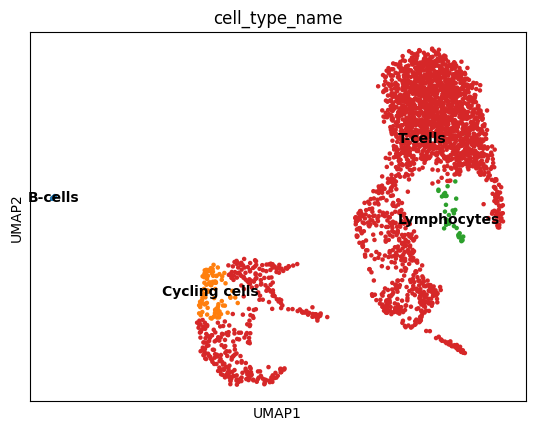

In [51]:
# now you can look at your umap with your labels!
sc.pl.umap(adata_merged, color = 'cell_type_name', legend_loc = 'on data')


In [52]:
adata_merged.obs.value_counts('leiden_2_sub')

leiden_2_sub
0.0     222
1.0     186
2.0     147
3.0     145
4.0     138
5.0     124
6.0     116
7.0     116
8.0     114
9.0     112
10.0    109
11.0    104
12.0     98
13.0     97
14.0     96
16.0     94
15.0     94
17.0     80
18.0     77
19.0     71
20.0     69
21.0     63
22.0     60
23.0     59
24.0     54
25.0     54
26.0     40
27.0     39
28.0     33
29.0     30
30.0      8
Name: count, dtype: int64

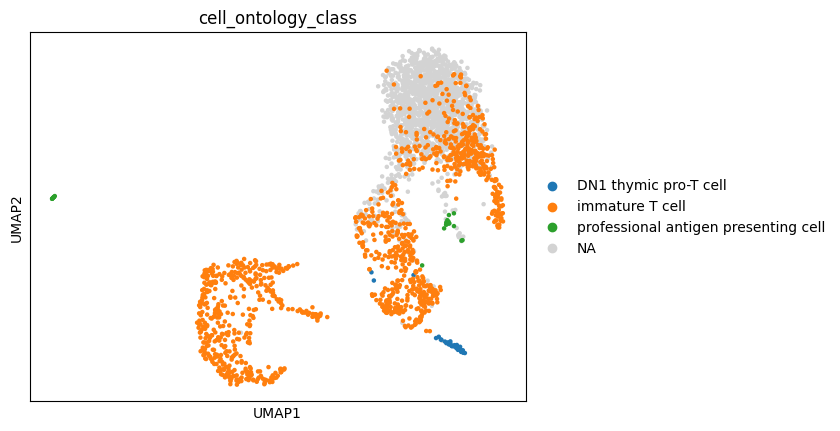

In [53]:
sc.pl.umap(adata_merged, color = 'cell_ontology_class')


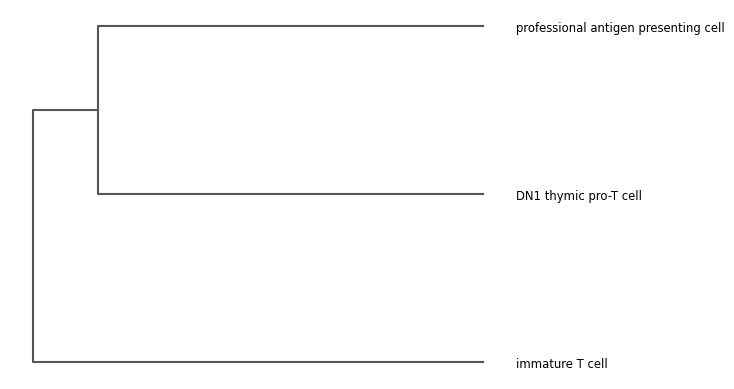

<Axes: >

In [54]:
sc.tl.dendrogram(adata_merged, groupby = 'cell_ontology_class')
sc.pl.dendrogram(adata_merged, groupby = 'cell_ontology_class', orientation = 'left')

In [55]:
# label the computed UMAP coordinates
adata_merged.obs['UMAP_X'] = pd.DataFrame(adata_merged.obsm['X_umap'])[0].values
adata_merged.obs['UMAP_Y'] = pd.DataFrame(adata_merged.obsm['X_umap'])[1].values




In [56]:
# create the cluster column with the column that you were using for clustering.
adata_merged.obs['clusters'] = adata_merged.obs['leiden_2_sub']

In [57]:
# read you filtered data again (we had filtered some genes and so on. 
#However we want all genes for the export and we only want to keep the UMAP coordinates,
# the labels and the clusters)
adata_all_genes = sc.read_h5ad(os.path.join(export_plots_directory, tissue + '_all_genes.h5ad'))

adata_all_genes.obs = adata_merged.obs
adata_all_genes.uns = adata_merged.uns
adata_all_genes.obsm = adata_merged.obsm
adata_all_genes.obsp = adata_merged.obsp


NameError: name 'export_plots_directory' is not defined

In [58]:
# here it saves a few plots, differentially expressed genes etc. 
with save_plots_to_pdf(os.path.join(export_plots_directory, 'cell_type_labelling.pdf')):
    
    sc.pl.umap(adata, color = 'clusters', legend_loc = 'on data', legend_fontsize = 8, title = tissue,  legend_fontoutline = 1 )

    sc.tl.dendrogram(adata, groupby = 'clusters')

    sc.pl.dendrogram(adata, groupby = 'clusters', orientation = 'left')
    sc.tl.dendrogram(adata, groupby = 'clusters')
    sc.pl.dotplot(adata, markers, "clusters", dendrogram=True, gene_symbols = 'gene_symbols' )


    sc.tl.rank_genes_groups(adata, groupby = 'clusters', method = 't-test_overestim_var')                                
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols='gene_symbols')
    sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby="clusters",gene_symbols = 'gene_symbols', min_logfoldchange = 2 )

    sc.pl.umap(adata, color = 'cell_type_simple', title = tissue)

    sc.pl.umap(adata, color = 'cell_type_name', title = tissue)
    sc.pl.umap(adata, color = 'cell_type_name', legend_loc = 'on data', legend_fontoutline = 1,
               legend_fontweight = 'normal', legend_fontsize = 6, )    
    sc.pl.dotplot(adata, markers, "cell_type_name", dendrogram=True, gene_symbols = 'gene_symbols' )



    sc.tl.dendrogram(adata, groupby = 'cell_type_name')
    sc.pl.dendrogram(adata, groupby = 'cell_type_name', orientation = 'left')
    
    sc.pl.umap(adata, color = 'confidence')
    sc.pl.umap(adata, color = 'mixed_cells')

    sc.tl.rank_genes_groups(adata, groupby = 'cell_type_name', method = 't-test_overestim_var')                                
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols='gene_symbols')
    sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, groupby="cell_type_name",gene_symbols = 'gene_symbols', min_logfoldchange = 2,  )


NameError: name 'export_plots_directory' is not defined

In [263]:
differential_expression = sc.get.rank_genes_groups_df(adata, group = None,pval_cutoff = 0.001,gene_symbols = 'gene_symbols', log2fc_min = 2  )

In [264]:
differential_expression.to_csv(os.path.join(export_plots_directory, 'dge_t-test_overestim_var.csv'))

In [265]:
# only if super sure; finish with. this will replace your filtered h5ad file. so be sure when you do it.
# otherwise you would have to run your filtering again. YOu can of course just change the name, but then you're saving a lot of data. 

# uncomment when ready: 

## adata_all_genes.write_h5ad(os.path.join(export_plots_directory, tissue + '_all_genes.h5ad'))

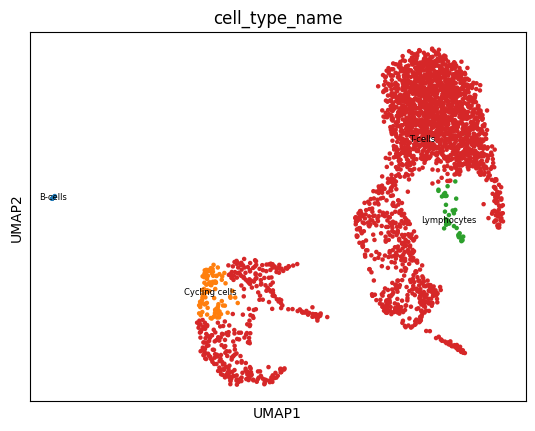

In [59]:
    sc.pl.umap(adata_merged, color = 'cell_type_name', legend_loc = 'on data',
               legend_fontweight = 'normal', legend_fontsize = 6, )


# Everything below is me exploring ways to define cell types, exploring different markers, viewing DEGs, etc. So you can ignore it, but maybe you find interesting things

categories: Adipocytes, Arterial enothelial cells, Capillary endothelial cells, etc.
var_group_labels: Increased cell cycling, decreased cell cycling, Endothelial cells, etc.


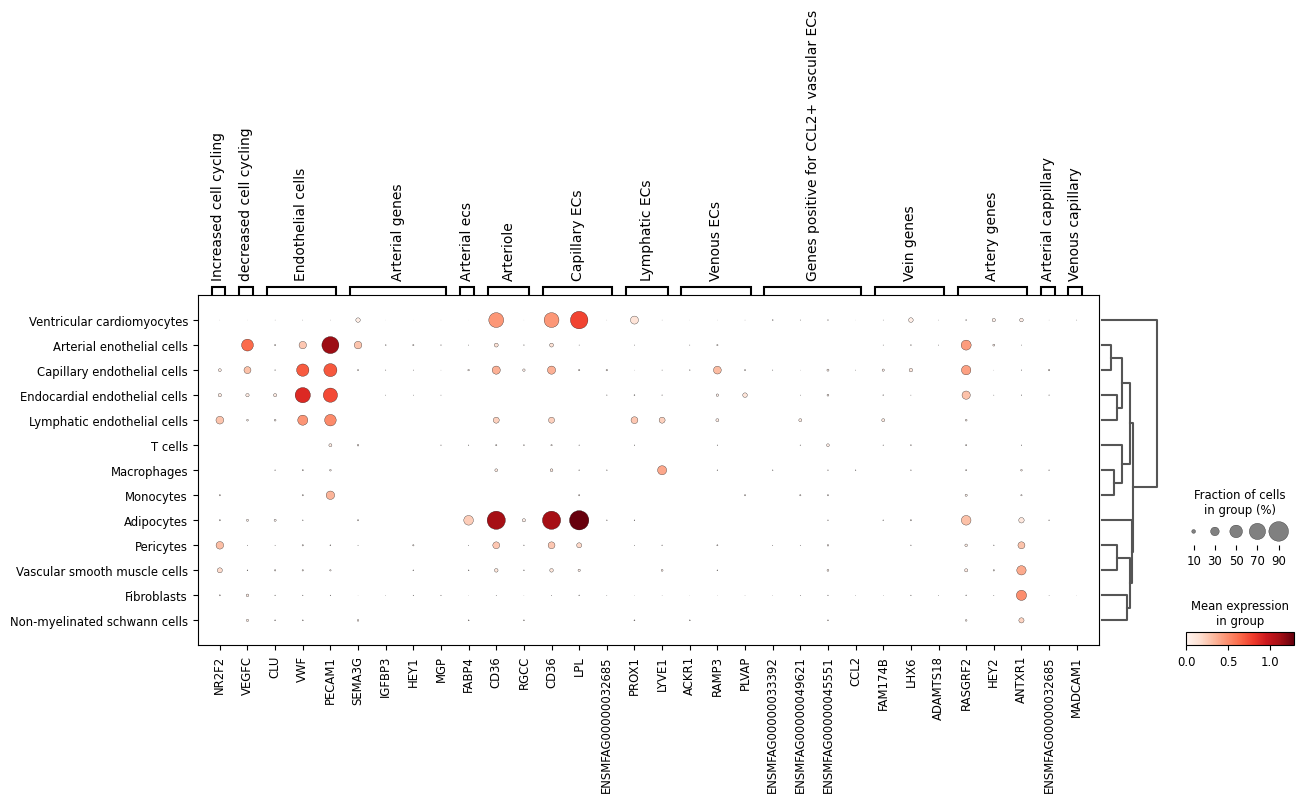

In [257]:
#https://www.nature.com/articles/s43587-024-00613-3/figures/14
#use to check all ECs
markers = {'Increased cell cycling':['NR2F2'],#https://www.nature.com/articles/s41569-022-00770-1/figures/1
    'decreased cell cycling':[ 'VEGFC'],#https://www.nature.com/articles/s41569-022-00770-1/figures/1
    #https://www.nature.com/articles/s43587-024-00613-3/figures/14
    'Endothelial cells':['PECAM1', 'VWF', 'CLDN5', 'CLU'],
    'Arterial genes': ['IGFBP3', 'HEY1', 'SEMA3G', 'MGP', 'GJA5'],
    'Arterial ecs':['FABP4', 'LGALA1'],
    'Arteriole':['RGCC', 'CD36'],
    'Capillary ECs':['CD36','CA4', 'LPL'], 
               'Lymphatic ECs':['LYVE1', 'PROX1'], #https://www.nature.com/articles/s43587-024-00613-3

    'Venous ECs':['ACKR1', 'PLVAP', 'CCL14', 'RAMP3'],
    'Genes positive for CCL2+ vascular ECs':['CCL2', 'SLC2A3', 'IRF1', 'ATF3', 'CDKN1A'],
           'Vein genes':['FAM174B', 'ADAMTS18', 'LHX6'],#https://www.nature.com/articles/s41569-022-00770-1/figures/1
    'Artery genes':['HEY2', 'ANTXR1', 'RASGRF2'],#https://www.nature.com/articles/s41569-022-00770-1/figures/1
   'Arterial cappillary':['CA4'],#and MADCAM-#https://www.nature.com/articles/s41586-021-03852-1/figures/6
   'Venous capillary':['MADCAM1'],#https://www.nature.com/articles/s41586-021-03852-1/figures/6

}
markers = htmd(markers, adata)
sc.pl.dotplot(adata, markers, "cell_type_name", dendrogram=True, gene_symbols = 'gene_symbols' )



#For artery cells
# decreased cycling --> artery

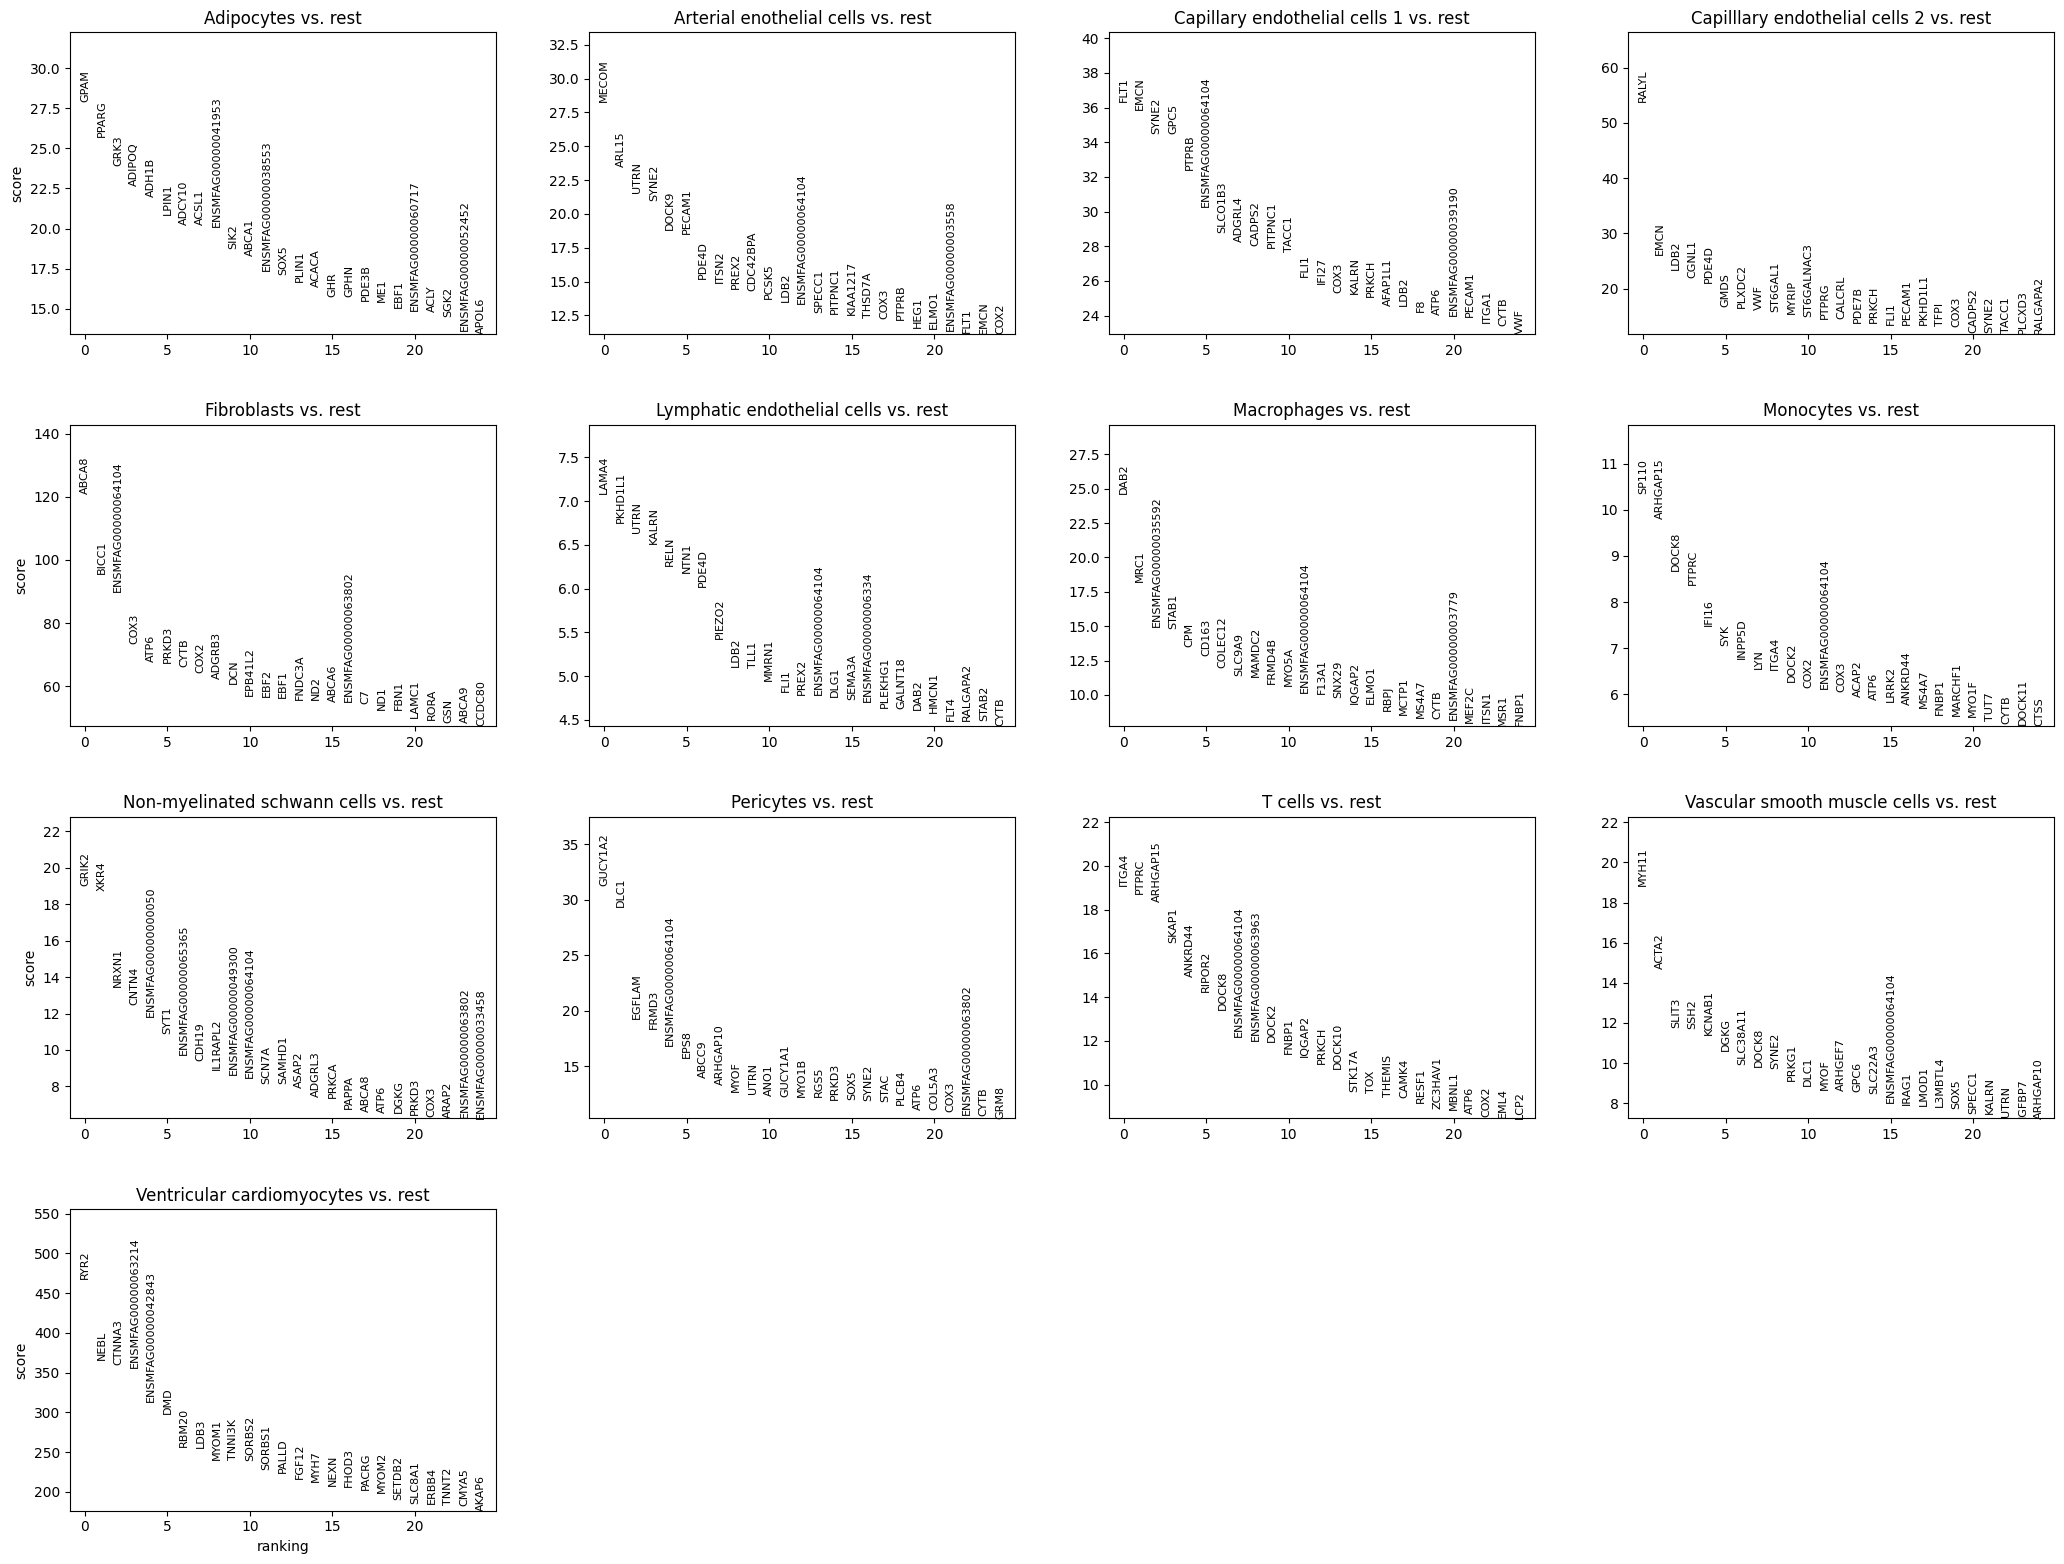

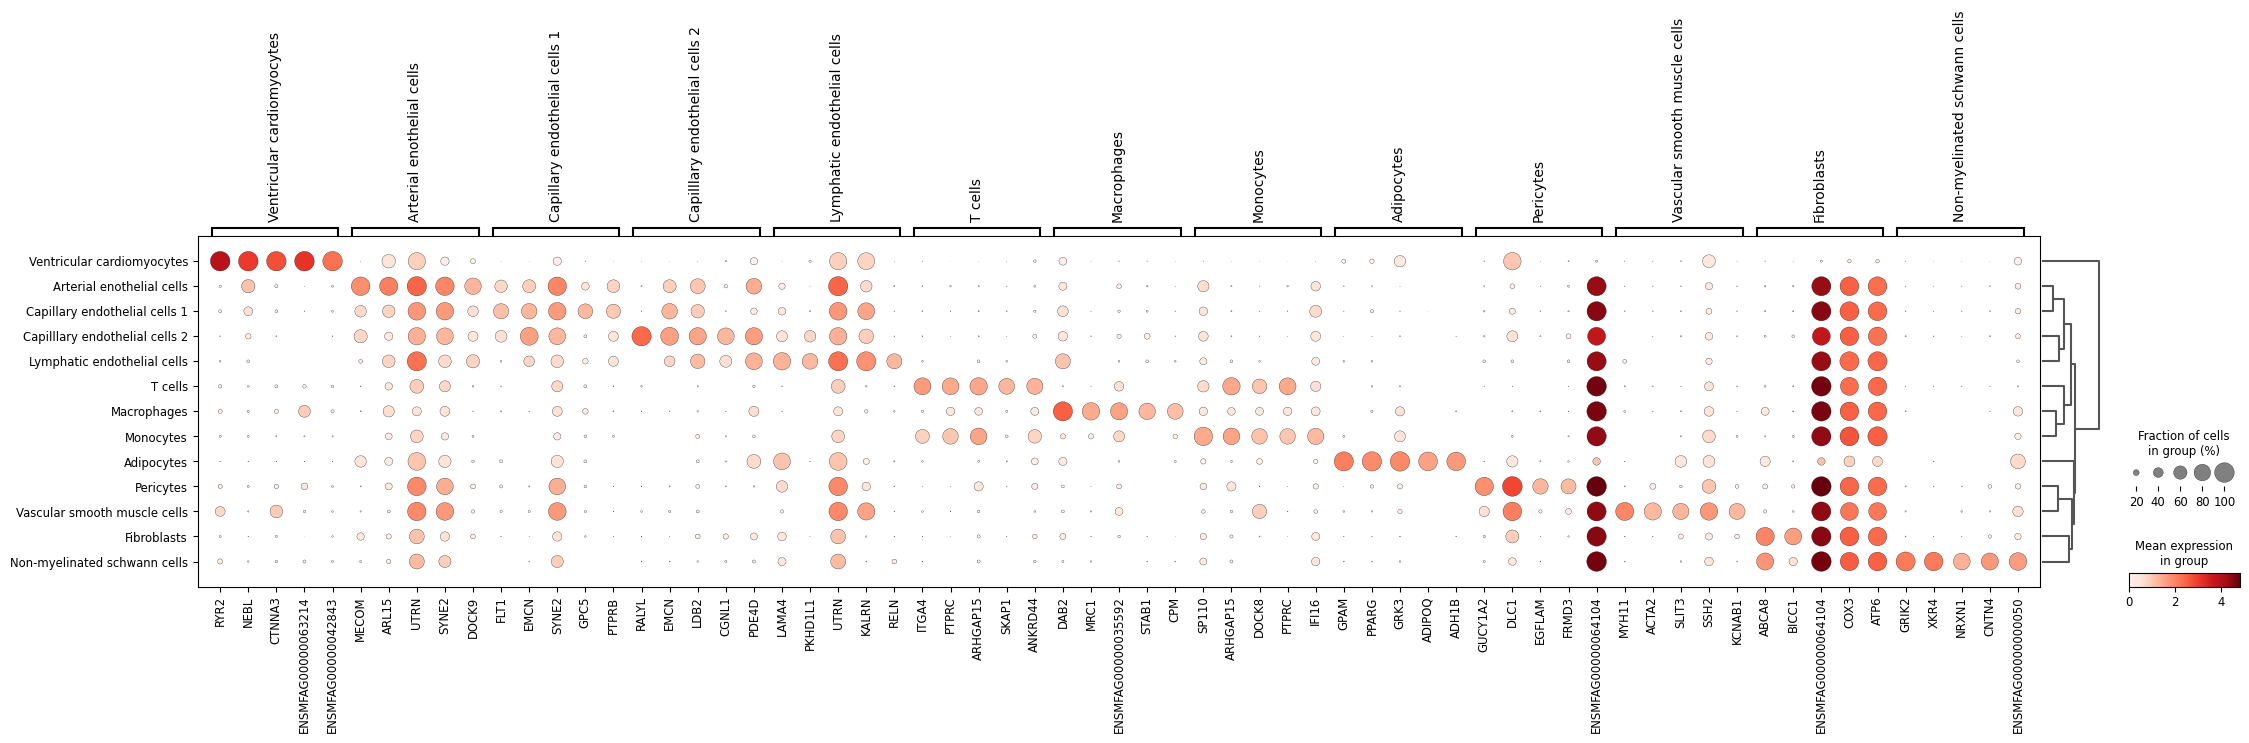

In [223]:
sc.tl.rank_genes_groups(adata, groupby = 'cell_type_name', method = 't-test_overestim_var')                                
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols='gene_symbols')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby="cell_type_name",gene_symbols = 'gene_symbols', min_logfoldchange = 2 )


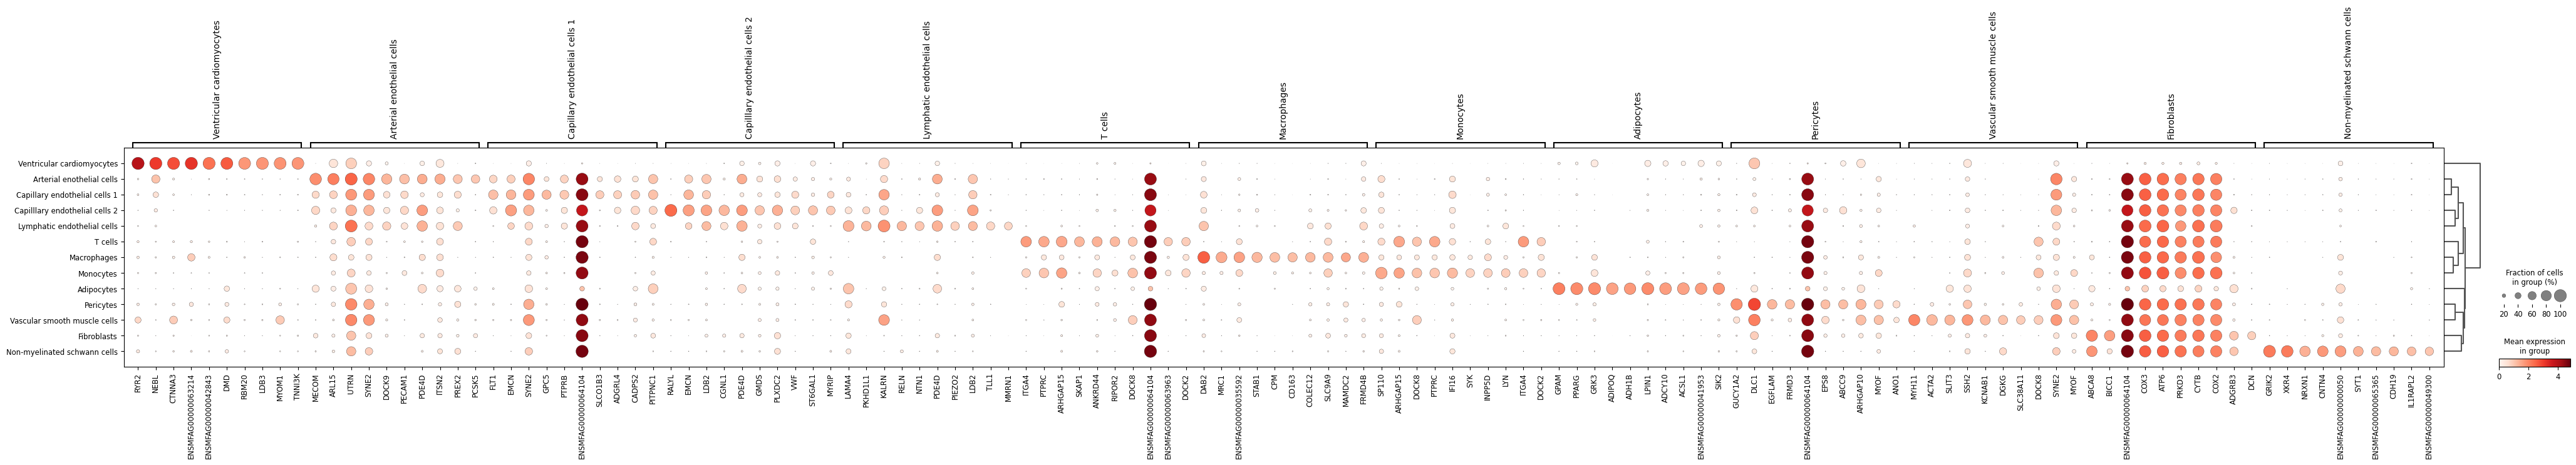

In [224]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, groupby="cell_type_name",gene_symbols = 'gene_symbols', min_logfoldchange = 2.5 )


categories: 0.0, 1.0, 2.0, etc.
var_group_labels: myofibers type I, myofibers type II, NMJ acc., etc.


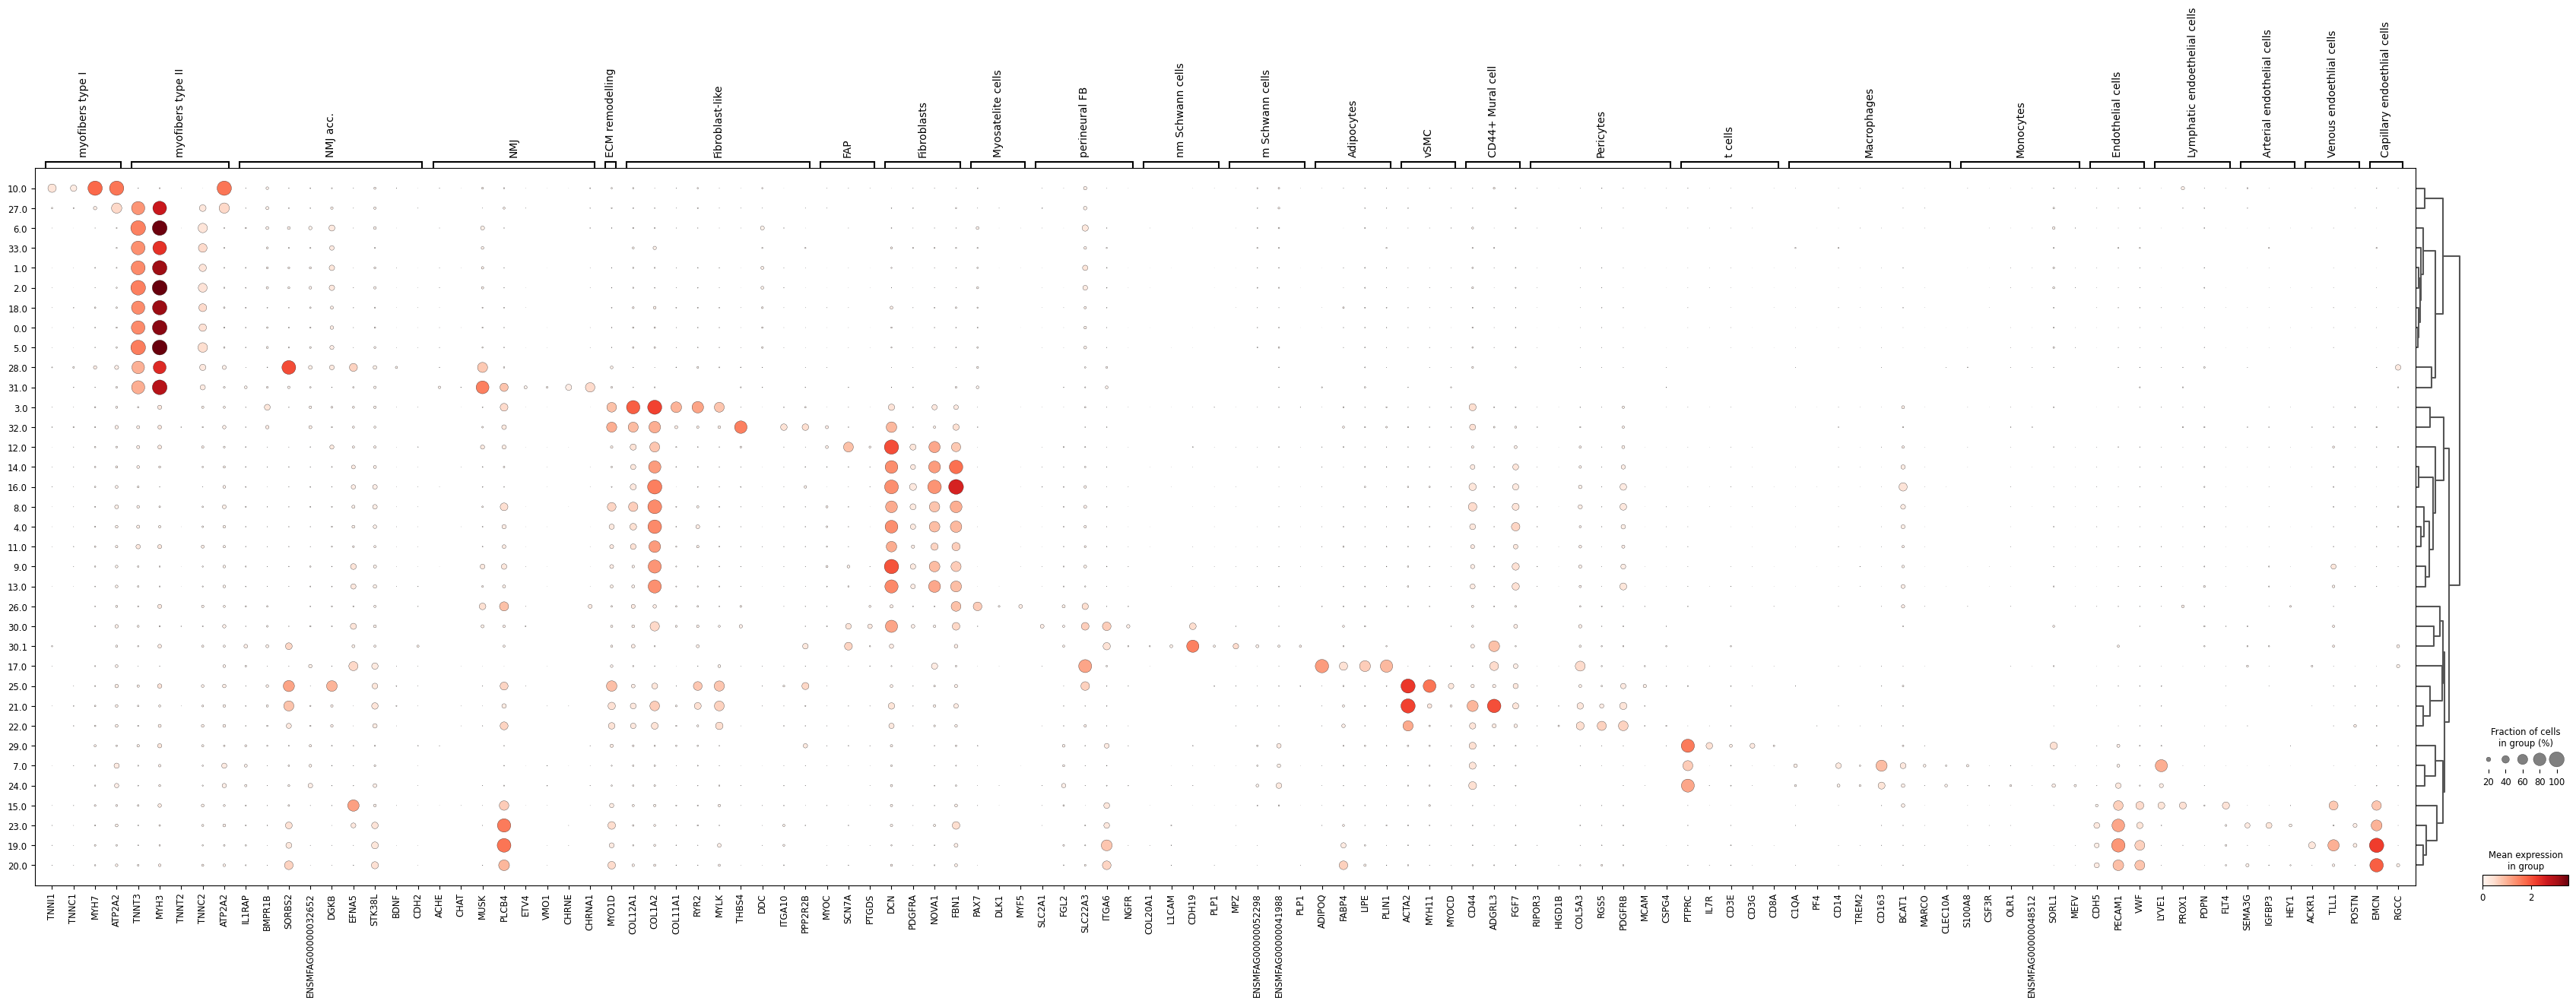

In [1008]:
markers = {
  'myofibers type I': ['TNNI1', 'TNNC1', 'MYH7', 'ATP2A2'],
  'myofibers type II': ['TNNT3', 'MYH3', 'TNNT2', 'TNNC2', 'ATP2A2'],
    'NMJ acc.': ['IL1RAP', 'BMPR1B', 'SORBS2', 'ENSMFAG00000032652', 'DGKB', 'EFNA5', 'STK38L', 'BDNF', 'CDH2'],
  'NMJ': ['ACHE', 'CHAT', 'MUSK', 'PLCB4', 'ETV4', 'VMO1', 'CHRNE', 'CHRNA1'],
  'ECM remodelling': ['MYO1D'],
  'Fibroblast-like':['COL12A1', 'COL1A2', 'COL11A1', 'RYR2', 'MYLK', 'THBS4', 'DDC', 'ITGA10', 'PPP2R2B'],
    'FAP': ['MYOC', 'SCN7A', 'PTGDS'],
      'Fibroblasts': ['DCN', 'PDGFRA', 'NOVA1', 'FBN1'],
      'Myosatelite cells': ['PAX7', 'DLK1', 'MYF5'],
  'perineural FB': ['SLC2A1', 'FGL2', 'SLC22A3', 'ITGA6', 'NGFR'],
  'nm Schwann cells': ['COL20A1', 'L1CAM', 'CDH19', 'PLP1'],
  'm Schwann cells': ['MPZ', 'ENSMFAG00000052298', 'ENSMFAG00000041988', 'PLP1'],
      'Adipocytes': ['ADIPOQ', 'FABP4', 'LIPE', 'PLIN1'],
      'vSMC': ['ACTA2', 'MYH11', 'MYOCD'],
   'CD44+ Mural cell': ['CD44', 'ADGRL3', 'FGF7'],#https://www.nature.com/articles/s41586-024-07348-6/figures/15
  'Pericytes':['RIPOR3', 'HIGD1B', 'COL5A3', 'RGS5', 'PDGFRB', 'MCAM', 'CSPG4'], 
  't cells':['PTPRC','IL7R',"CD3E", 'CD3G', 'CD8A'],
  'Macrophages':  ['C1QA', 'PF4', 'CD14', 'TREM2', 'CD163', 'BCAT1', 'MARCO', 'CLEC10A'],##https://www.nature.com/articles/s43587-024-00613-3/figures/16
  'Monocytes': ['S100A8', 'CSF3R', 'OLR1', 'ENSMFAG00000048512', 'SORL1', 'MEFV'],
  'Endothelial cells': ['CDH5', 'PECAM1','VWF'],
  'Lymphatic endoethelial cells': [ 'LYVE1', 'PROX1', 'PDPN', 'FLT4'],
  'Arterial endothelial cells':  ['SEMA3G','IGFBP3','HEY1'],
  'Venous endoethlial cells': [  'ACKR1',  'TLL1',   'POSTN' ],
  'Capillary endoethlial cells': ['EMCN',  'RGCC']


}
sc.pl.dotplot(adata, markers, "leiden_2_sub", dendrogram=True, gene_symbols = 'gene_symbols' )


categories: Adipocytes, Arterial endothelial cells, CD44+ mural cells, etc.
var_group_labels: myofibers type I, mypfibers type II, NMJ acc., etc.


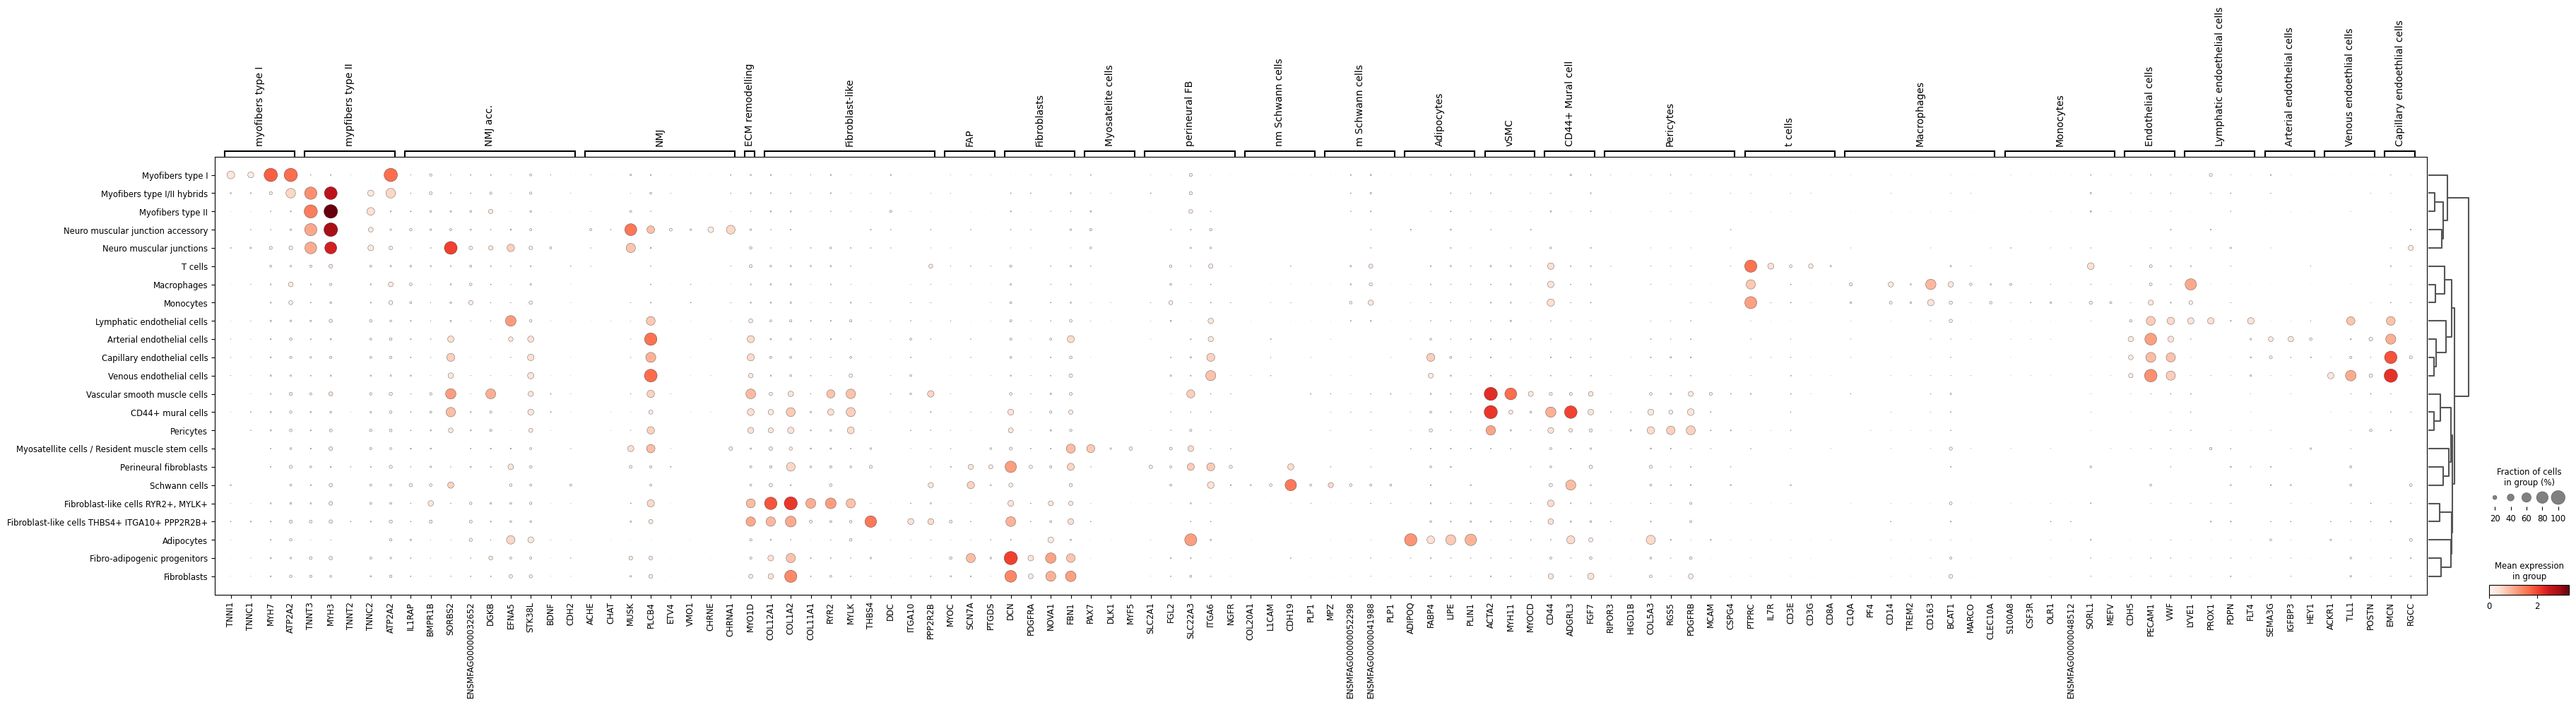

In [955]:
sc.pl.dotplot(adata, markers, "cell_type_name", dendrogram=True, gene_symbols = 'gene_symbols' )


In [979]:
adata.obs

pct_unspliced  doublet_score  \
Abdominal_wall_217:AACACCTGATAACTTGCACC      75.108840       0.051186   
Abdominal_wall_217:AACACCTGATAGACCGTCGT      79.373650       0.074675   
Abdominal_wall_217:AACACCTGATATCAGAGTCA      73.073190       0.038988   
Abdominal_wall_217:AACACCTGATGATTGATGGC      77.570591       0.025641   
Abdominal_wall_217:AACACTCTCCCGATCACGAT      75.108069       0.024834   
...                                                ...            ...   
Abdominal_wall_215:TTGTCTGCAGACATAGGTGG      72.500000       0.028961   
Abdominal_wall_215:TTGTCTGCAGCTCGATTGGT      77.063011       0.030783   
Abdominal_wall_215:TTGTGGCATCAGCAAGCGAC      76.165347       0.049447   
Abdominal_wall_215:TTGTGGCATCCTTCAATAAT      78.858746       0.097816   
Abdominal_wall_215:TTGTGGCATCGCTCTCGGTT      73.355913       0.042017   

                                         predicted_doublet  \
Abdominal_wall_217:AACACCTGATAACTTGCACC              False   
Abdominal_wall_217:AACACCTGATAGACCGTCGT              False   
Abdominal_wall_217:AACACCTGATATCAGAGTCA              False   
Abdominal_wall_217:AACACCTGATGATTGATGGC              False   
Abdominal_wall_217:AACACTCTCCCGATCACGAT              False   
...                                                    ...   
Abdominal_wall_215:TTGTCTGCAGACATAGGTGG              False   
Abdominal_wall_215:TTGTCTGCAGCTCGATTGGT              False   
Abdominal_wall_215:TTGTGGCATCAGCAAGCGAC              False   
Abdominal_wall_215:TTGTGGCATCCTTCAATAAT              False   
Abdominal_wall_215:TTGTGGCATCGCTCTCGGTT              False   

                                                  ori_barcode  \
Abdominal_wall_217:AACACCTGATAACTTGCACC  AACACCTGATAACTTGCACC   
Abdominal_wall_217:AACACCTGATAGACCGTCGT  AACACCTGATAGACCGTCGT   
Abdominal_wall_217:AACACCTGATATCAGAGTCA  AACACCTGATATCAGAGTCA   
Abdominal_wall_217:AACACCTGATGATTGATGGC  AACACCTGATGATTGATGGC   
Abdominal_wall_217:AACACTCTCCCGATCACGAT  AACACTCTCCCGATCACGAT   
...                                                       ...   
Abdominal_wall_215:TTGTCTGCAGACATAGGTGG  TTGTCTGCAGACATAGGTGG   
Abdominal_wall_215:TTGTCTGCAGCTCGATTGGT  TTGTCTGCAGCTCGATTGGT   
Abdominal_wall_215:TTGTGGCATCAGCAAGCGAC  TTGTGGCATCAGCAAGCGAC   
Abdominal_wall_215:TTGTGGCATCCTTCAATAAT  TTGTGGCATCCTTCAATAAT   
Abdominal_wall_215:TTGTGGCATCGCTCTCGGTT  TTGTGGCATCGCTCTCGGTT   

                                                     sample  \
Abdominal_wall_217:AACACCTGATAACTTGCACC  Abdominal_wall_217   
Abdominal_wall_217:AACACCTGATAGACCGTCGT  Abdominal_wall_217   
Abdominal_wall_217:AACACCTGATATCAGAGTCA  Abdominal_wall_217   
Abdominal_wall_217:AACACCTGATGATTGATGGC  Abdominal_wall_217   
Abdominal_wall_217:AACACTCTCCCGATCACGAT  Abdominal_wall_217   
...                                                     ...   
Abdominal_wall_215:TTGTCTGCAGACATAGGTGG  Abdominal_wall_215   
Abdominal_wall_215:TTGTCTGCAGCTCGATTGGT  Abdominal_wall_215   
Abdominal_wall_215:TTGTGGCATCAGCAAGCGAC  Abdominal_wall_215   
Abdominal_wall_215:TTGTGGCATCCTTCAATAAT  Abdominal_wall_215   
Abdominal_wall_215:TTGTGGCATCGCTCTCGGTT  Abdominal_wall_215   

                                               ref_Celltype  \
Abdominal_wall_217:AACACCTGATAACTTGCACC  Type IIb myonuclei   
Abdominal_wall_217:AACACCTGATAGACCGTCGT        Stromal cell   
Abdominal_wall_217:AACACCTGATATCAGAGTCA  Type IIb myonuclei   
Abdominal_wall_217:AACACCTGATGATTGATGGC  Type IIb myonuclei   
Abdominal_wall_217:AACACTCTCCCGATCACGAT  Type IIb myonuclei   
...                                                     ...   
Abdominal_wall_215:TTGTCTGCAGACATAGGTGG  Type IIa myonuclei   
Abdominal_wall_215:TTGTCTGCAGCTCGATTGGT                 NaN   
Abdominal_wall_215:TTGTGGCATCAGCAAGCGAC                 NaN   
Abdominal_wall_215:TTGTGGCATCCTTCAATAAT                 NaN   
Abdominal_wall_215:TTGTGGCATCGCTCTCGGTT        Stromal cell   

                                           ref_Abbreviation macaque_id  \
Abdominal_wall_217:AACACCTGATAACTTGCACC  Type IIb 

In [1034]:
adata_all_genes.X.max()

555.0

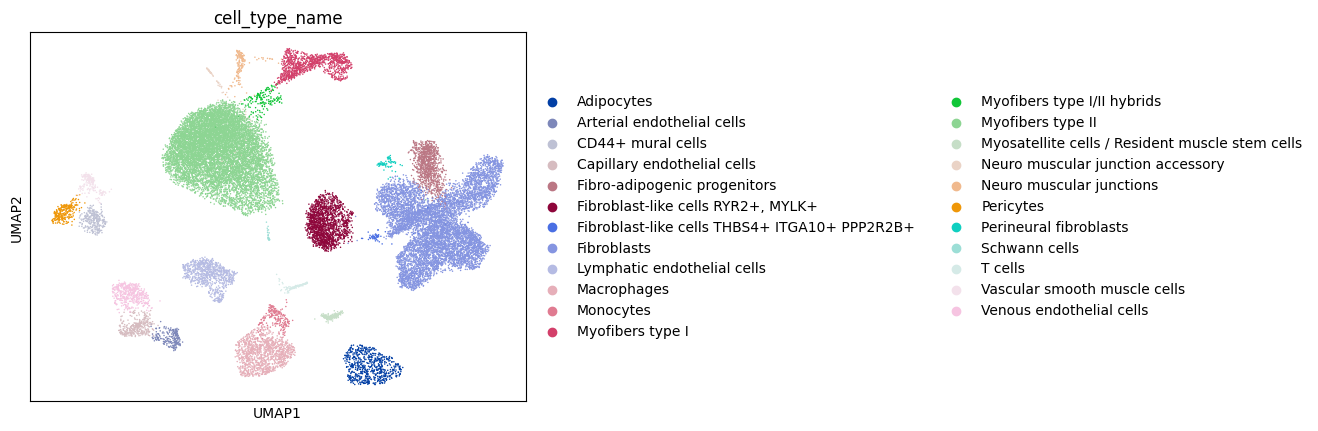

In [882]:
sc.tl.dendrogram(adata, groupby = 'leiden_2_sub')

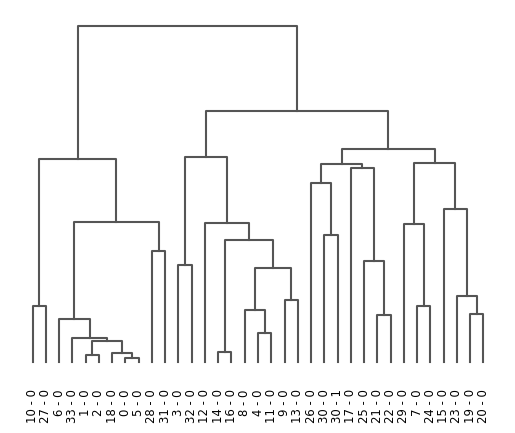

<Axes: >

In [868]:
sc.pl.dendrogram(adata, groupby = 'leiden_2_sub')

In [385]:
tmp = pd.crosstab(adata_merged.obs['leiden_2'],adata_merged.obs['ref_Celltype'], normalize='index')
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.4, 1),loc='upper right')

KeyError: 'ref_Celltype'

In [35]:
hpa_markers = pd.read_csv('/Users/emilioskarwan/Documents/SciLifeDrive/macaque_sc/data/metadata/cell_markers/cell_type_markers.tsv', sep = '\t')

hpa_markers = hpa_markers[hpa_markers['gene_ids'].isin(adata.var_names)]

In [36]:

hpa_markers_dict = hpa_markers.dropna()[['gene_symbols','cell_type_name']].groupby('cell_type_name')['gene_symbols'].apply(list).to_dict()

In [37]:
hpa_markers_dict

{'Adipocytes': ['ADIPOQ', 'FABP4', 'LIPE', 'PLIN1'],
 'Alveolar cells type 1': ['AGER', 'CAV1'],
 'Alveolar cells type 2': ['LAMP3', 'NAPSA'],
 'Astrocytes': ['ALDH1L1', 'AQP4', 'GFAP', 'SLC14A1', 'SLC1A3'],
 'B cells': ['CD19', 'CD79A', 'CR2', 'MS4A1'],
 'Basal keratinocytes': ['COL17A1', 'KRT5'],
 'Basal prostatic cells': ['KRT5', 'NGFR', 'TP63'],
 'Basal respiratory cells': ['COL17A1', 'KRT5', 'NGFR', 'TP63'],
 'Basal squamous epithelial cells': ['COL17A1'],
 'Bipolar cells': ['GRM6', 'TRPM1'],
 'Breast glandular cells': ['CSN2', 'ESR1'],
 'Breast myoepithelial cells': ['TP63'],
 'Cardiomyocytes': ['MYH7', 'MYL2', 'MYL7'],
 'Club cells': ['BPIFB1', 'CYP4B1', 'CYP51A1', 'MUC15'],
 'Collecting duct cells': ['CLDN8', 'PVALB', 'TMEM213'],
 'Cone photoreceptor cells': ['GNAT2'],
 'Cytotrophoblasts': ['PAGE4', 'PEG10'],
 'Dendritic cells': ['CD1E', 'GZMB'],
 'Distal enterocytes': ['CDH17', 'GPA33', 'KRT20'],
 'Distal tubular cells': ['SLC12A1', 'TMEM213', 'TMEM72', 'UMOD'],
 'Ductal cells

categories: 0.0, 1.0, 2.0, etc.
var_group_labels: Adipocytes, Alveolar cells type 1, Alveolar cells type 2, etc.


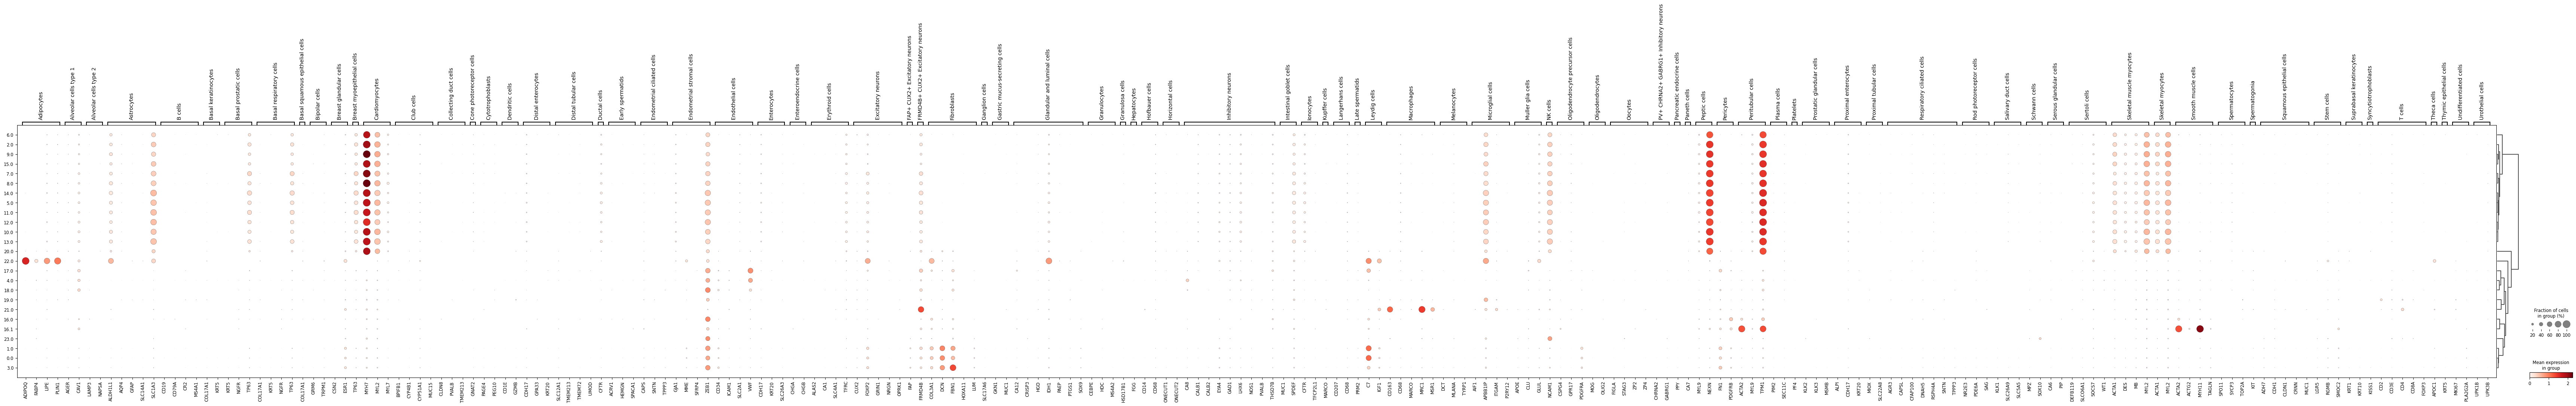

In [38]:
sc.pl.dotplot(adata, hpa_markers_dict, "leiden_2_sub", dendrogram=True, gene_symbols = 'gene_symbols' )


In [ ]:
adar